# Продвинутое глубокое обучение и обучение с подкреплением: ДЗ №1

**Булаев Владимир, группа DS-32, 11.10-22.10.2021**

Примечание:
- Для решения всех проблем с отображением выложил файл на nbviewer
- Ссылка на оригинальный файл в репозитории: https://github.com/bulaevvi/Advanced-ML/blob/main/AdvancedRL_DL_HW1.ipynb

## Содержание: <a class="anchor" id="zero-bullet"></a>
* [Часть I, с блекджеком и стратегиями](#I)
    * [1. Оценка выигрыша простой стратегии](#1)
    * [2. Реализация метода обучения с подкреплением без модели](#2)
    * [3. Оценка выигрыша обученной стратегии](#3)
* [Часть II, удвоенная](#II)
    * [4. Реализация варианта блекджека с удвоением ставки](#4)
    * [5. Обучение стратегии для блекджека с удвоением ставки](#5)
* [Часть III, в главной роли — Дастин Хоффман](#III)
    * [6. Реализация варианта блекджека с удвоением ставки и подсчетом карт](#6)
    * [7. Обучение стратегии для блекджека с удвоением ставки и подсчетом карт](#7)
* [Часть IV, опциональная](#IV)
    * [8. Решение уравнений Беллмана](#8)   

In [1]:
# Команда для установки нужной версии gym
# pip install gym==0.17.3

In [1]:
# Используемые бибилиотеки
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
# В зависимости от версии sklearn работает _testing или testing
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
from collections import defaultdict
from IPython.display import clear_output

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (14, 6)
legend_fontsize = 12

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Часть I, с блекджеком и стратегиями <a class="anchor" id="I"></a>  

**Описание задачи:** 
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.
Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
- численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;  
- туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;  
- игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
- игрок может совершать одно из двух действий:  
    - hit  — взять ещё одну карту;  
    - stand — не брать больше карт;  
- если сумма очков у игрока на руках больше 21, он проигрывает (bust);  
- если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;  
- после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);  
- в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).  

Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py  

[К содержанию](#zero-bullet) 

### 1. Оценка выигрыша простой стратегии <a class="anchor" id="1"></a>  

Условие задачи: *Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.*

In [2]:
env = gym.make('Blackjack-v0', natural = True)

CUT_OFF = 19 # Значение, после которого игрок говорит Stand

# Простая стратегия
def pi_simple(obs):
    return [1,0] if obs[0] >= CUT_OFF else [0,1]

# Функция для проведения экспериментов и отрисовки результатов 
def run_experiments(env, episodes, pi, plot = True):
    env.reset()
    rewards = []
    for i in range(episodes):
        # Визуализация прогресса
        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end = '')
            clear_output(wait = True)
        done = False
        while not done:
            action = np.argmax(pi(env._get_obs()))
            obs, reward, done, _ = env.step(action)
            if done:
                rewards.append(reward)
                env.reset() 
    
    average_rewards = np.true_divide(np.cumsum(np.array(rewards)), np.arange(1, episodes + 1))
    if plot:
        plt.figure(figsize = figsize)
        plt.plot(average_rewards)
        plt.xlabel('Количество эпизодов')
        plt.ylabel('Средний выигрыш')
        plt.show()    
        print ('Средний выигрыш после {} эпизодов: {}'.format(episodes, average_rewards[-1]))
        
    return average_rewards[-1]

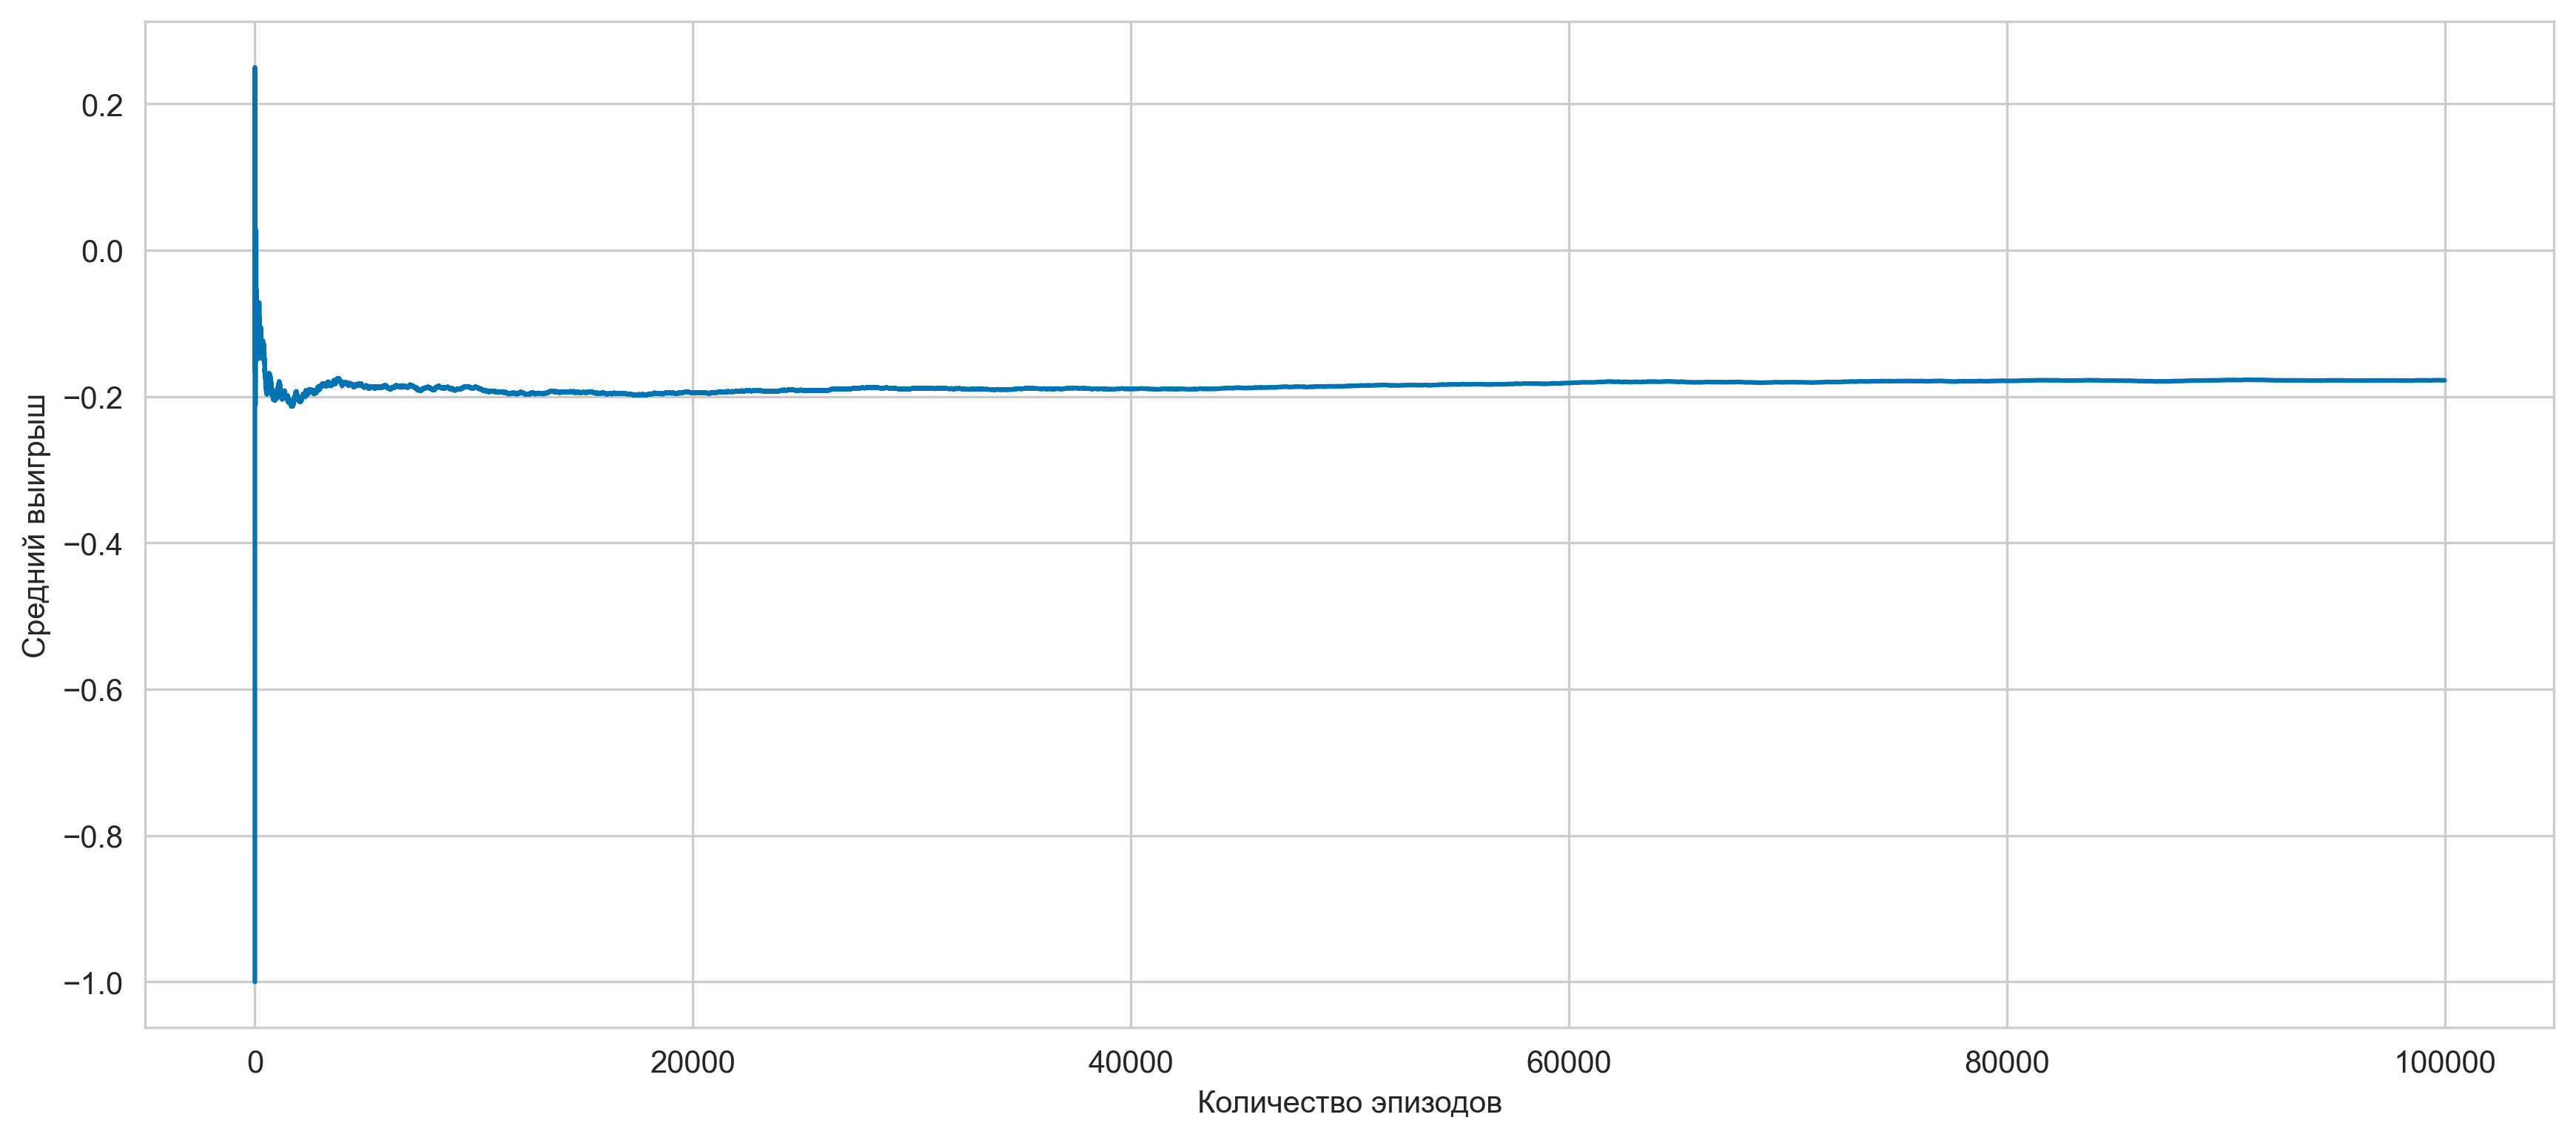

Средний выигрыш после 100000 эпизодов: -0.17791
Wall time: 9.86 s


In [3]:
%%time
run_experiments(env, 100_000, pi_simple)

Посмотрим что будет, если говорить stand после 17 (как дилер)

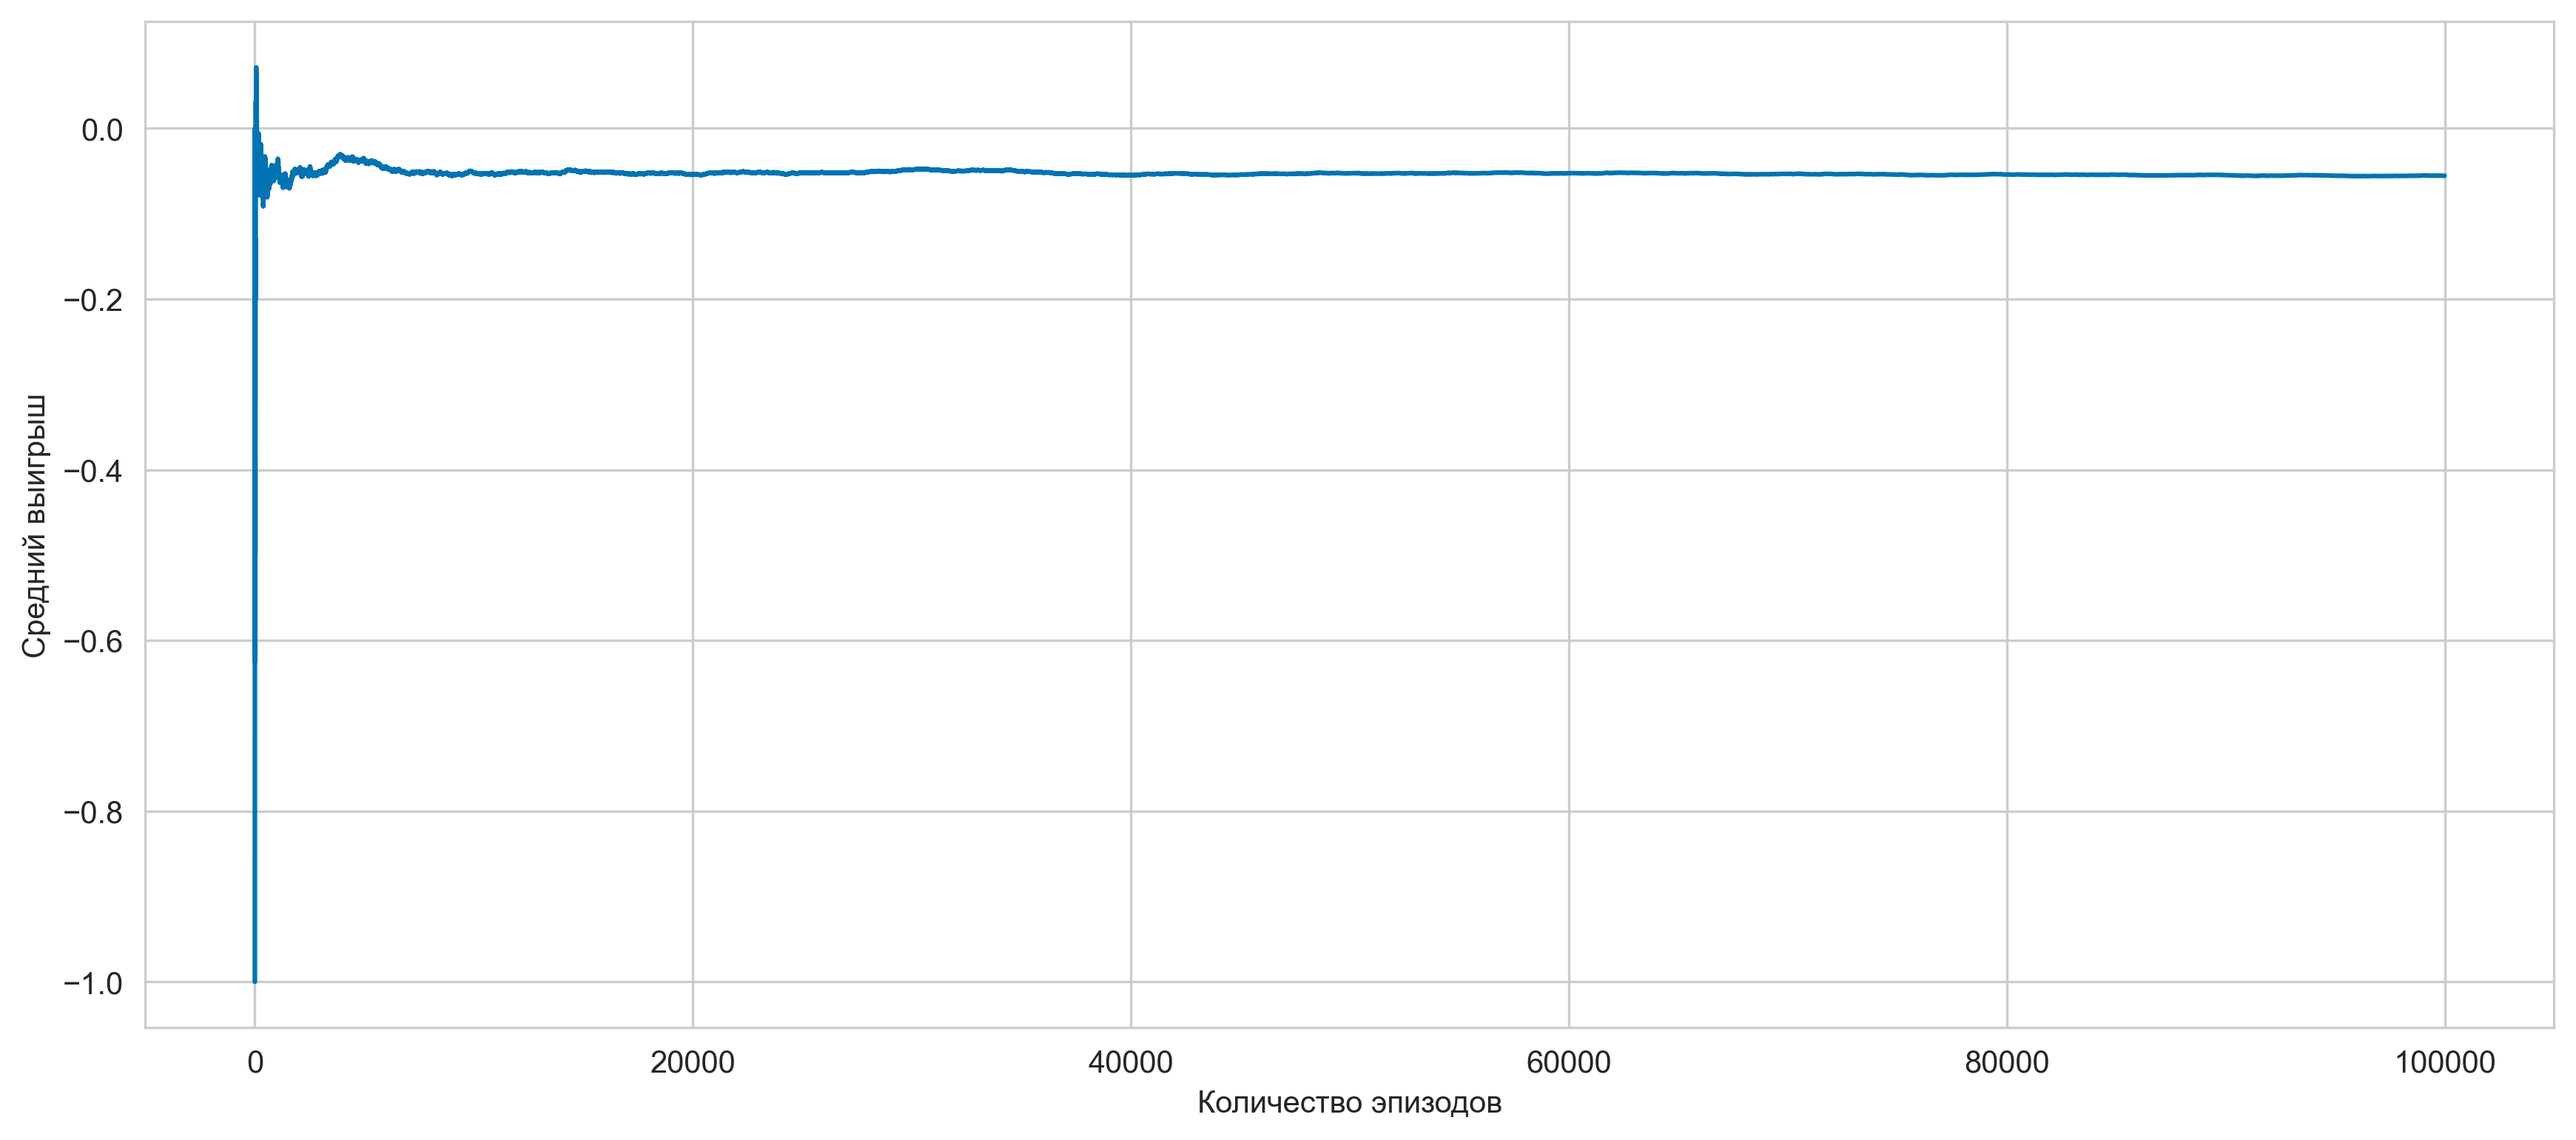

Средний выигрыш после 100000 эпизодов: -0.05559


In [4]:
CUT_OFF = 17
run_experiments(env, 100_000, pi_simple)

[К содержанию](#zero-bullet) 

### 2. Реализация метода обучения с подкреплением без модели среды <a class="anchor" id="2"></a>

Условие задачи: *Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.*

**Решение:**  опробуем следующие алгоритмы:  
1) On-police Monte Carlo control, оптимизирующее эпсилон-жадную стратегию  
2) Q-learning

In [3]:
# Эпсилон-жадная стратегия
def pi_epsilon_greedy(env, Q, epsilon):
    def policy(obs):
        nA = env.action_space.n
        probs = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[obs])
        probs[best_action] = 1.0 - epsilon + (epsilon / nA)
        return probs
    return policy

# On-policy Monte Carlo Control, оптимизирующая эпсилон-жадную стратегию
def on_policy_mc_control(env, episodes, gamma, epsilon):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    pol = pi_epsilon_greedy(env, Q, epsilon)
    
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end = '')
            clear_output(wait = True)

        episode = []
        state = env.reset()
        is_done = False
        while not is_done:
            probs = pol(state) 
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_state, reward, is_done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #First Visit MC:
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (gamma ** i) for i, x in enumerate(episode[first_occurence_idx:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    
    return Q, pol

# Q-Learning Method
def Q_learning(env, episodes, gamma, epsilon, alpha):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i in range(1, episodes + 1):
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end = '')
            clear_output(wait = True)
        eps = max(1.0 / i, epsilon) # сокращам эпсилон со временем, чтобы прийти к жадной стратегии
        curr_state = env.reset()
        while True:
            probs = pi_epsilon_greedy(env, Q, eps)(curr_state)
            curr_act = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(curr_act)
            if not done: 
                next_act = np.argmax(Q[next_state]) 
                td_target = reward + gamma * Q[next_state][next_act]
                td_error = td_target - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                curr_state = next_state
            if done: 
                td_error = reward - Q[curr_state][curr_act]
                Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error
                break
            
    return Q, pi_epsilon_greedy(env, Q, eps)

Обучим стратегии с помощью алгоритмов Q-learning и On-policy Monte Carlo control

In [25]:
%%time
episodes, gamma, eps = 200_000, 1, 0.05
_, pi_q  = Q_learning(env = env, episodes = episodes, gamma = gamma, epsilon = eps, alpha = 0.001)
_, pi_mc = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Wall time: 55.1 s


[К содержанию](#zero-bullet) 

### 3. Оценка выигрыша обученной стратегии <a class="anchor" id="3"></a>

Условие задачи: *Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.*

Средний выигрыш стратегии, обученной методом Q-learning:

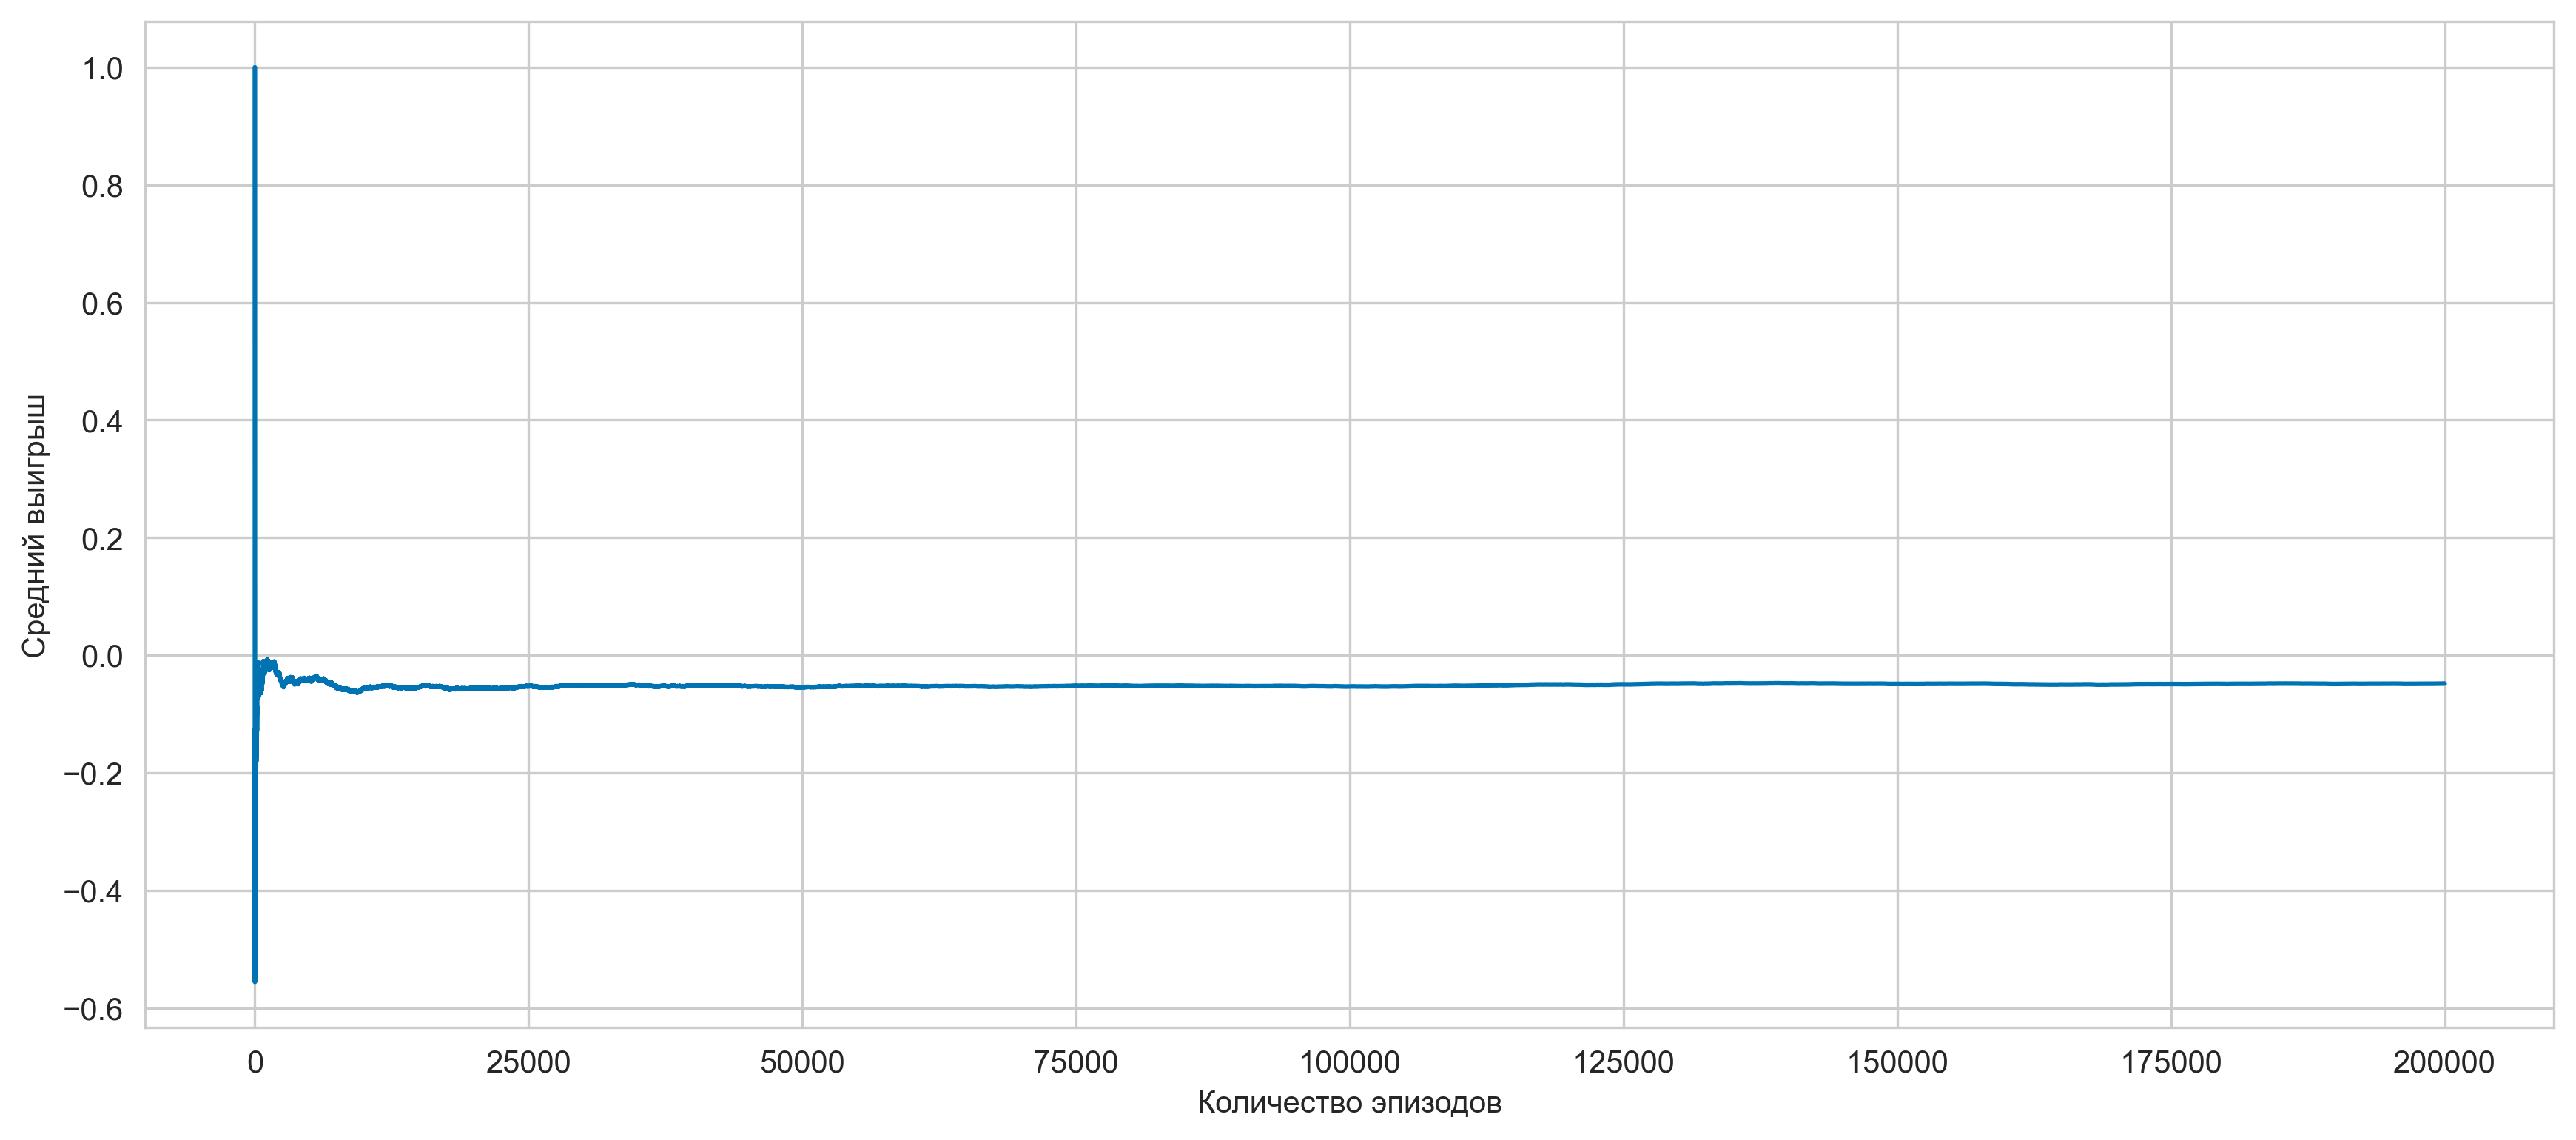

Средний выигрыш после 200000 эпизодов: -0.048135
Wall time: 18.6 s


In [26]:
%%time
episodes = 200_000
run_experiments(env, episodes, pi_q)

Средний выигрыш стратегии, обученной методом On-policy Monte Carlo control:

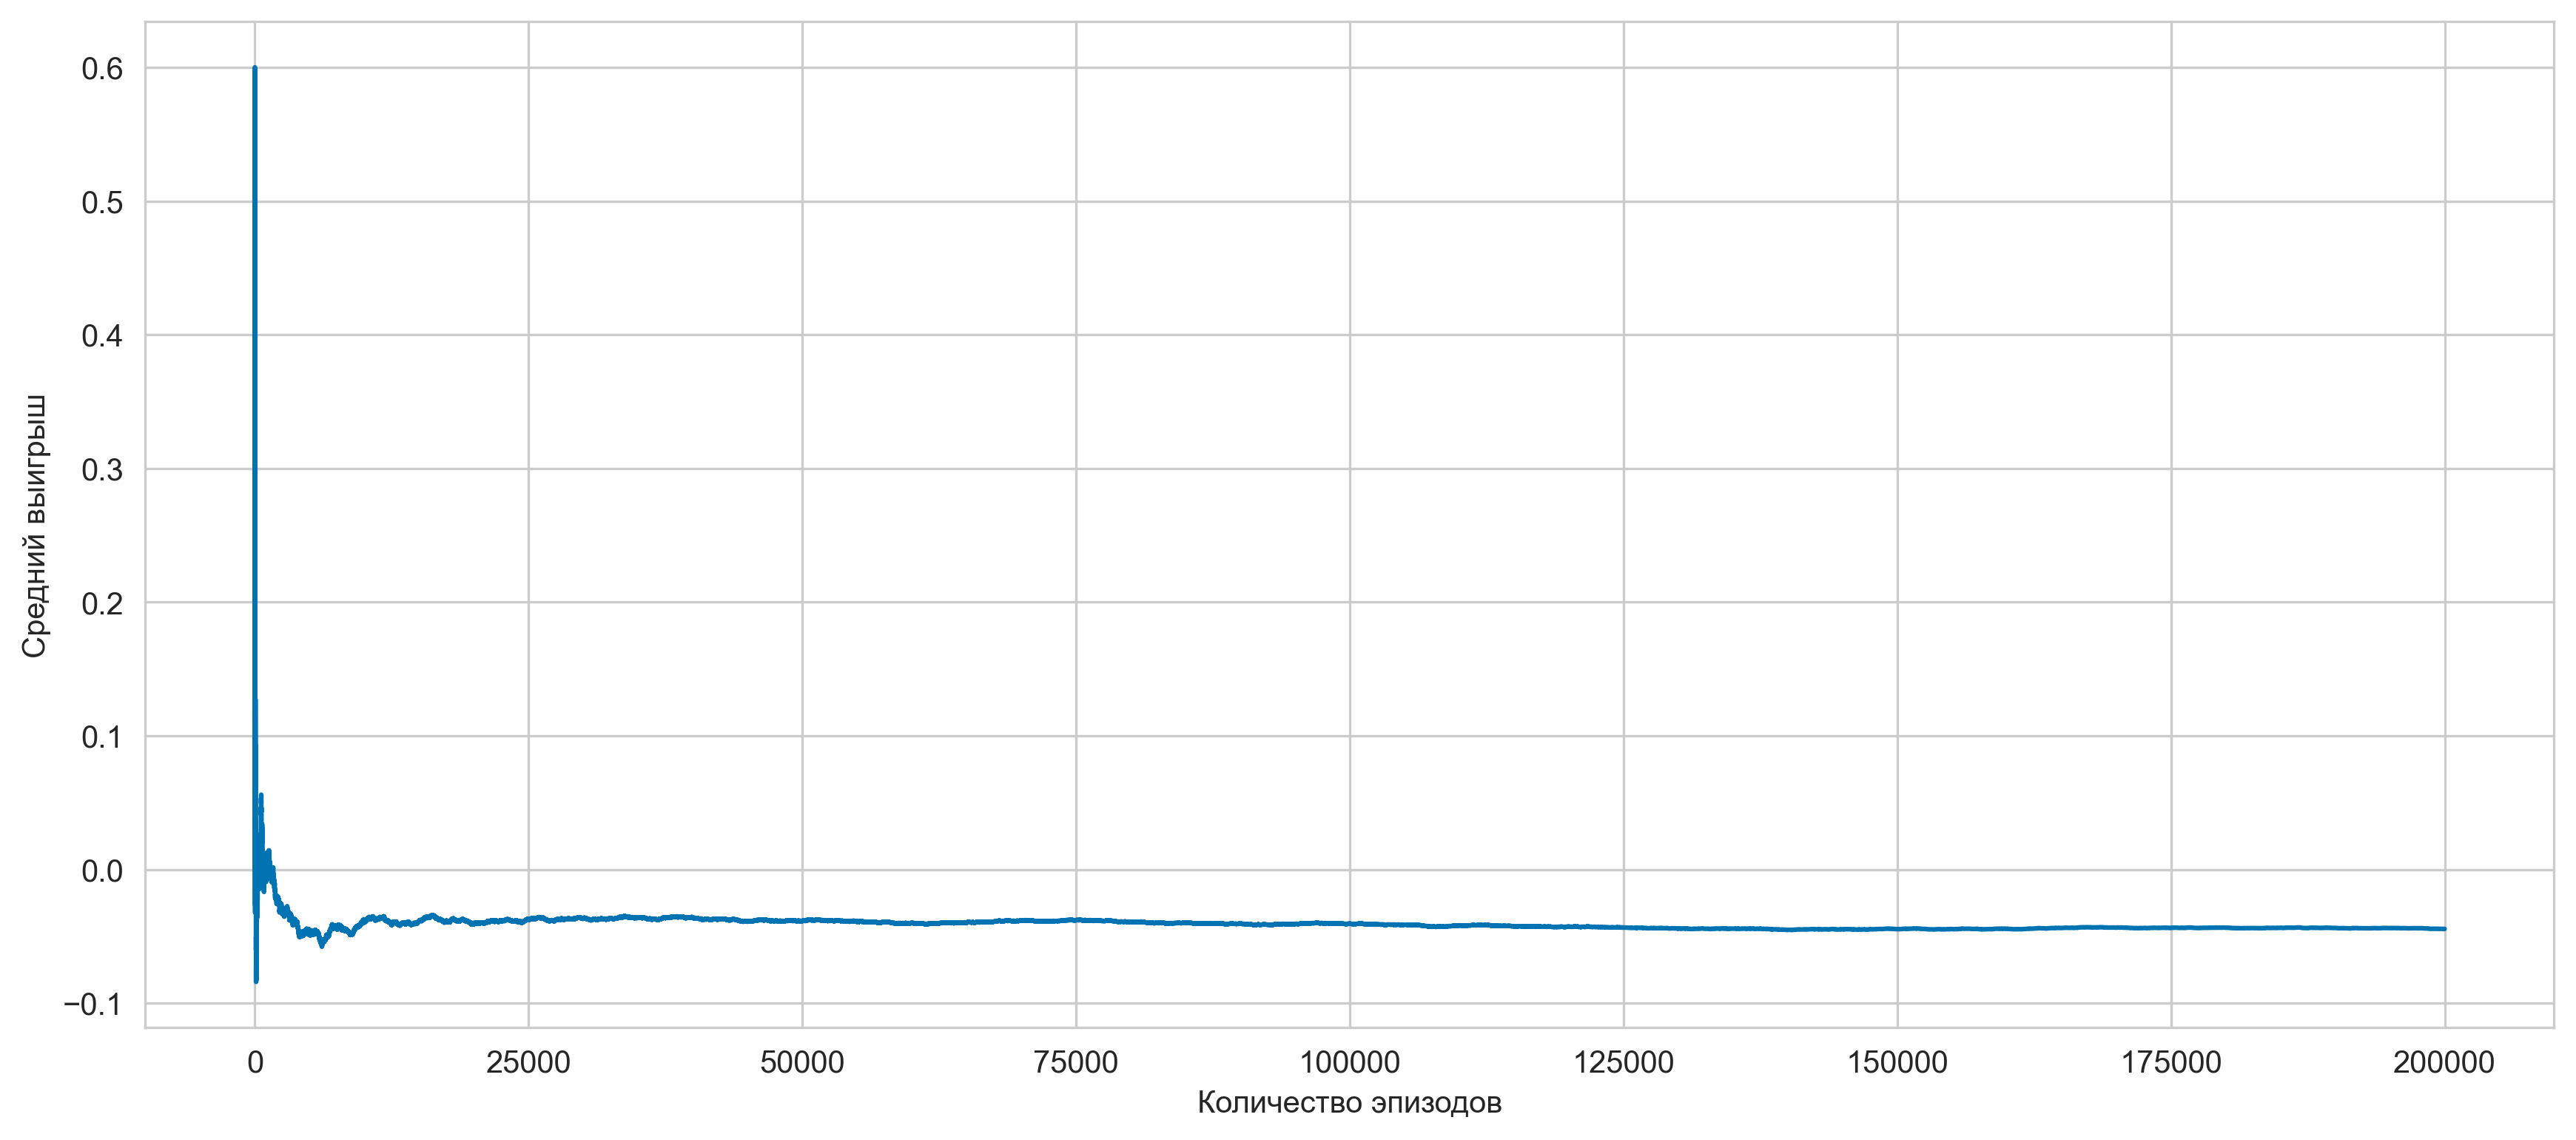

Средний выигрыш после 200000 эпизодов: -0.0444475
Wall time: 18.3 s


In [27]:
%%time
run_experiments(env, episodes, pi_mc)

**Выводы:** средний выигрыш обученных стратегий по результатам 200_000 сыгранных эпизодов составляет:  
- для Q-learning: -0.048135;
- для On-policy MC-control: -0.0444475.

Стратегия, обученная по Монте Карло, показала чуть лучший результат. Используем ее для подбора гиперпараметров. Для ускорения процесса используем 100_000 эпизодов.

In [30]:
%%time
episodes = 100_000
gamma_list = [1, 0.95, 0.9, 0.8]
eps_list = [0.01, 0.05, 0.1, 0.2]
best_avg_reward = -np.inf
best_hyperparameters = None
for gamma in gamma_list:
    for eps in eps_list:
        Q, pi = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)
        avg_reward = run_experiments(env = env, episodes = episodes, pi = pi_mc, plot = False) 
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_hyperparameters = (gamma, eps)

print(f'Best (gamma, eps): {best_hyperparameters}')
print(f'Average reward: {best_avg_reward}')

Best (gamma, eps): (0.9, 0.2)
Average reward: -0.03631
Wall time: 6min 9s


Используя подобранные гиперпараметры, попробуем обучить стратегию на большом количестве эпизодов, а затем сыграть обученной стратегией 1_000_000 игр.

In [31]:
%%time
episodes, gamma, eps = 1_000_000, 0.9, 0.2
_, pi_mc_best = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Wall time: 2min 24s


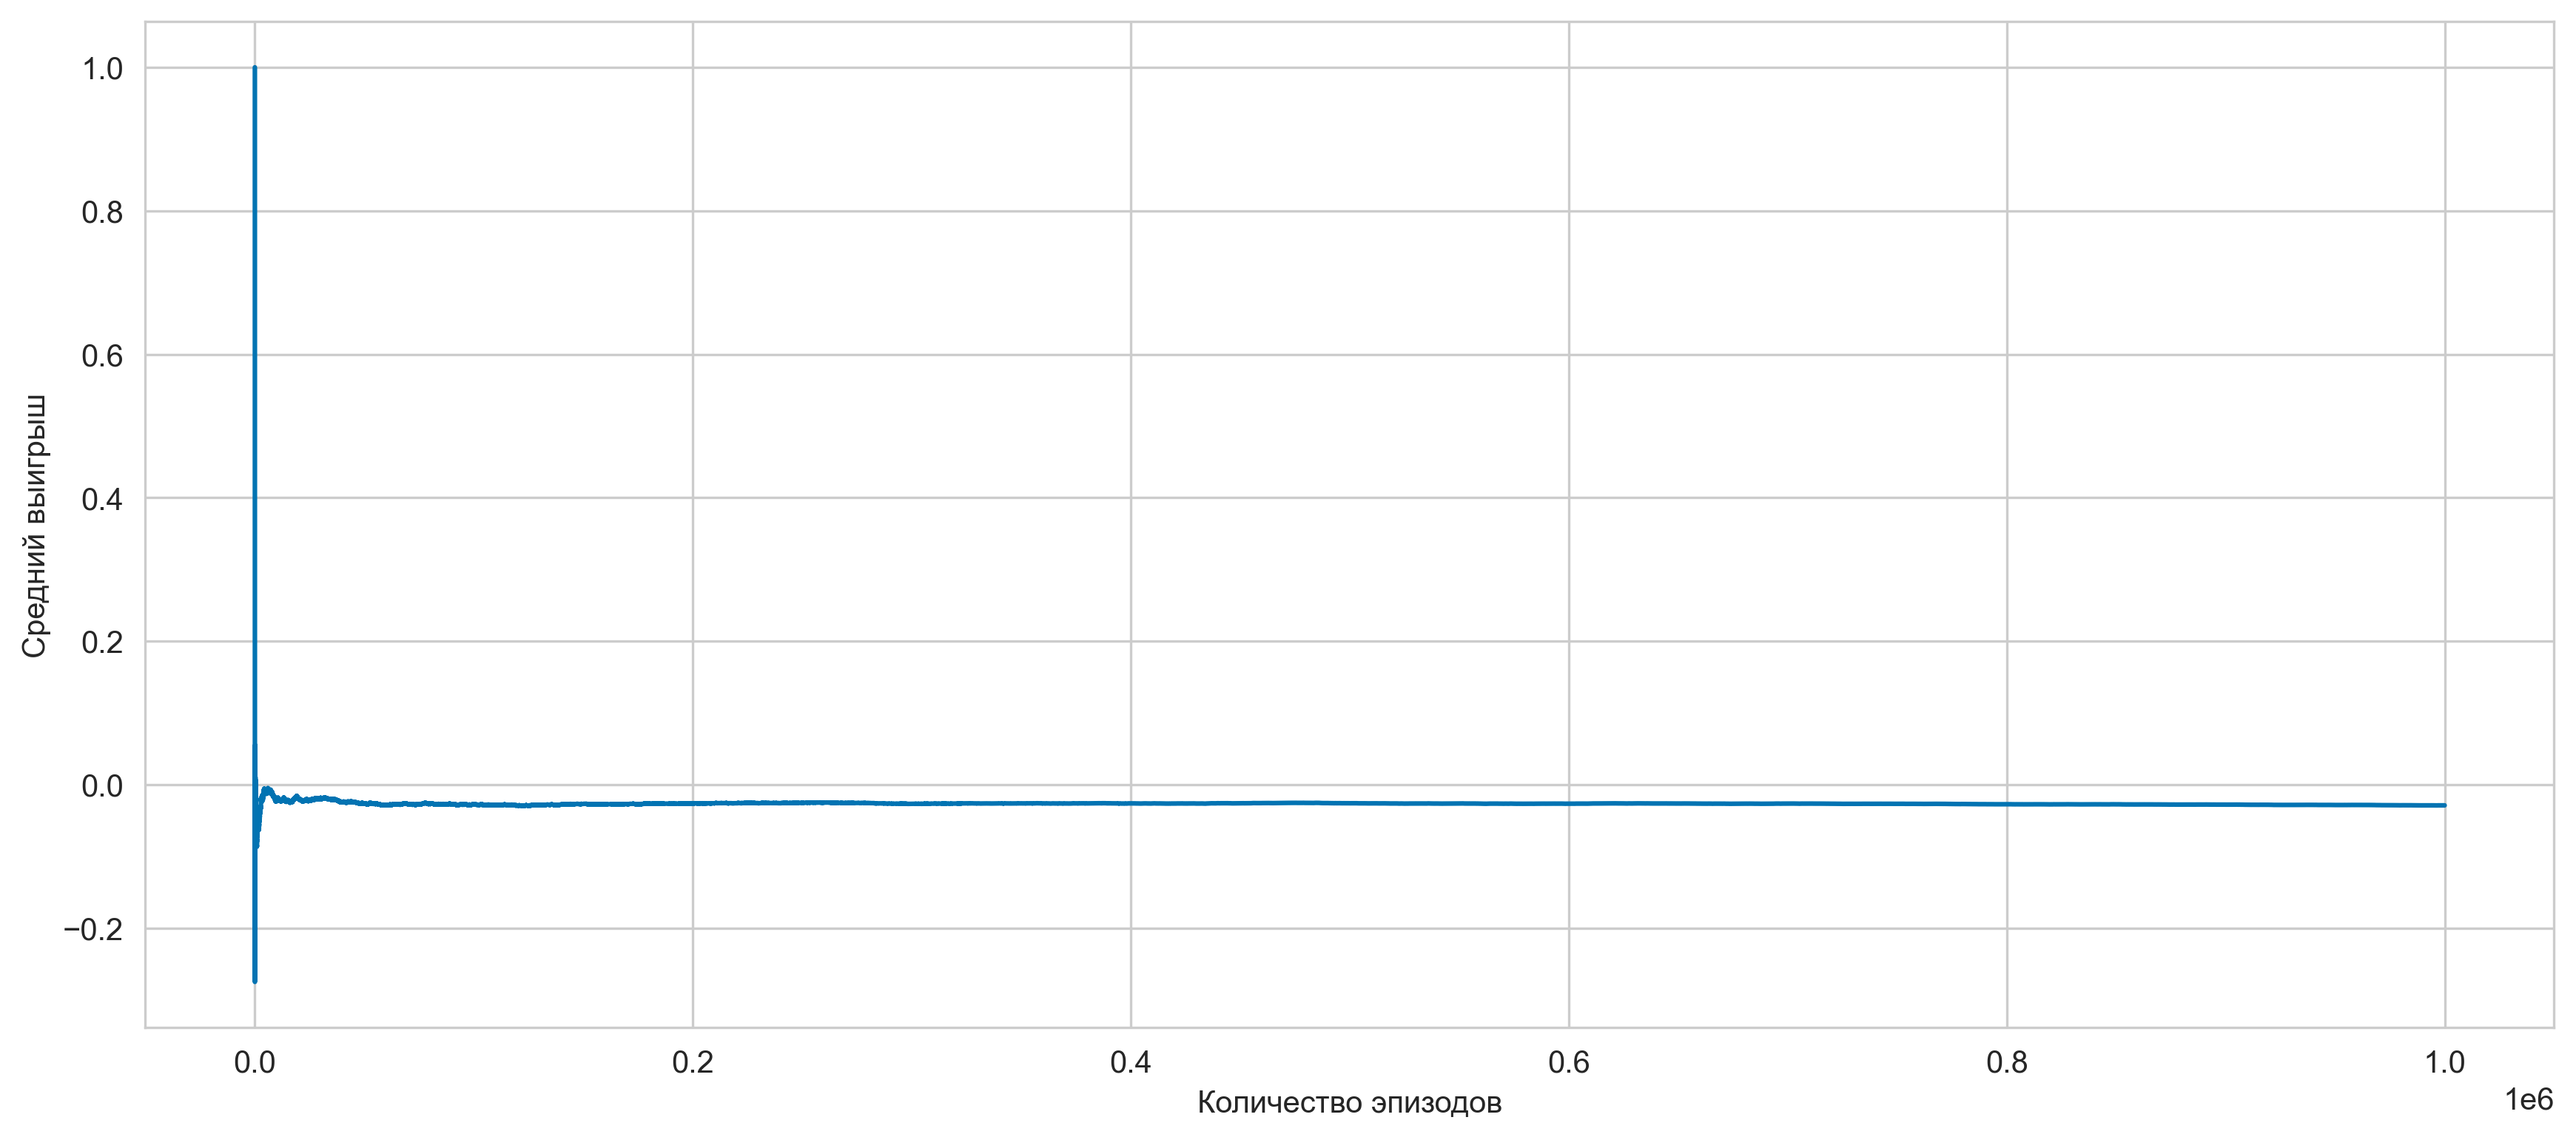

Средний выигрыш после 1000000 эпизодов: -0.028921
Wall time: 1min 30s


-0.028921

In [32]:
%%time
run_experiments(env, episodes, pi_mc_best)

In [33]:
env.close()

**Выводы по части I:**  
1) Простая стратегия при отсечке в 19 очков дает средний выигрыш -0.17791. Если сделать отсечку как у дилера, получим -0.05559  
2) В обычном блэкджеке с базовыми параметрами episodes, gamma, eps = 200_000, 1, 0.05 обучение стратегии методом On-policy Monte Carlo control позволила повысить средний выигрыш до -0.0444475. Причем, On-policy Monte Carlo control дало лучший результат, чем Q-learning.  
3)  Подбор гиперпараметров и последующее обучение на 1_000_000 эпизодов позволил еще более повысить средний выигрыш до -0.028921.  
4)  Не смотря на все ухищрения, казино тем не менее все равно оказывается в плюсе.  

[К содержанию](#zero-bullet) 

## Часть II, удвоенная <a class="anchor" id="II"></a>  

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:  
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализация варианта блекджека с удвоением ставки <a class="anchor" id="4"></a>  

Условие задачи: *Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.*

In [4]:
# from https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]

def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21

def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

class DoubleBlackjackEnv(gym.Env):
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3) # add third action
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # double action
            self.player.append(draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2 # double reward
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()
    
    def show_cards(self):
        return self.player

In [48]:
env = DoubleBlackjackEnv(True)

[К содержанию](#zero-bullet) 
### 5. Обучение стратегии для блекджека с удвоением ставки <a class="anchor" id="5"></a>

Условие задачи: *Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2-3.*

In [49]:
%%time
episodes, gamma, eps = 200_000, 1, 0.05
_, pi_q  = Q_learning(env = env, episodes = episodes, gamma = gamma, epsilon = eps, alpha = 0.001)
_, pi_mc = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Wall time: 54.2 s


Средний выигрыш стратегии, обученной методом Q-learning:

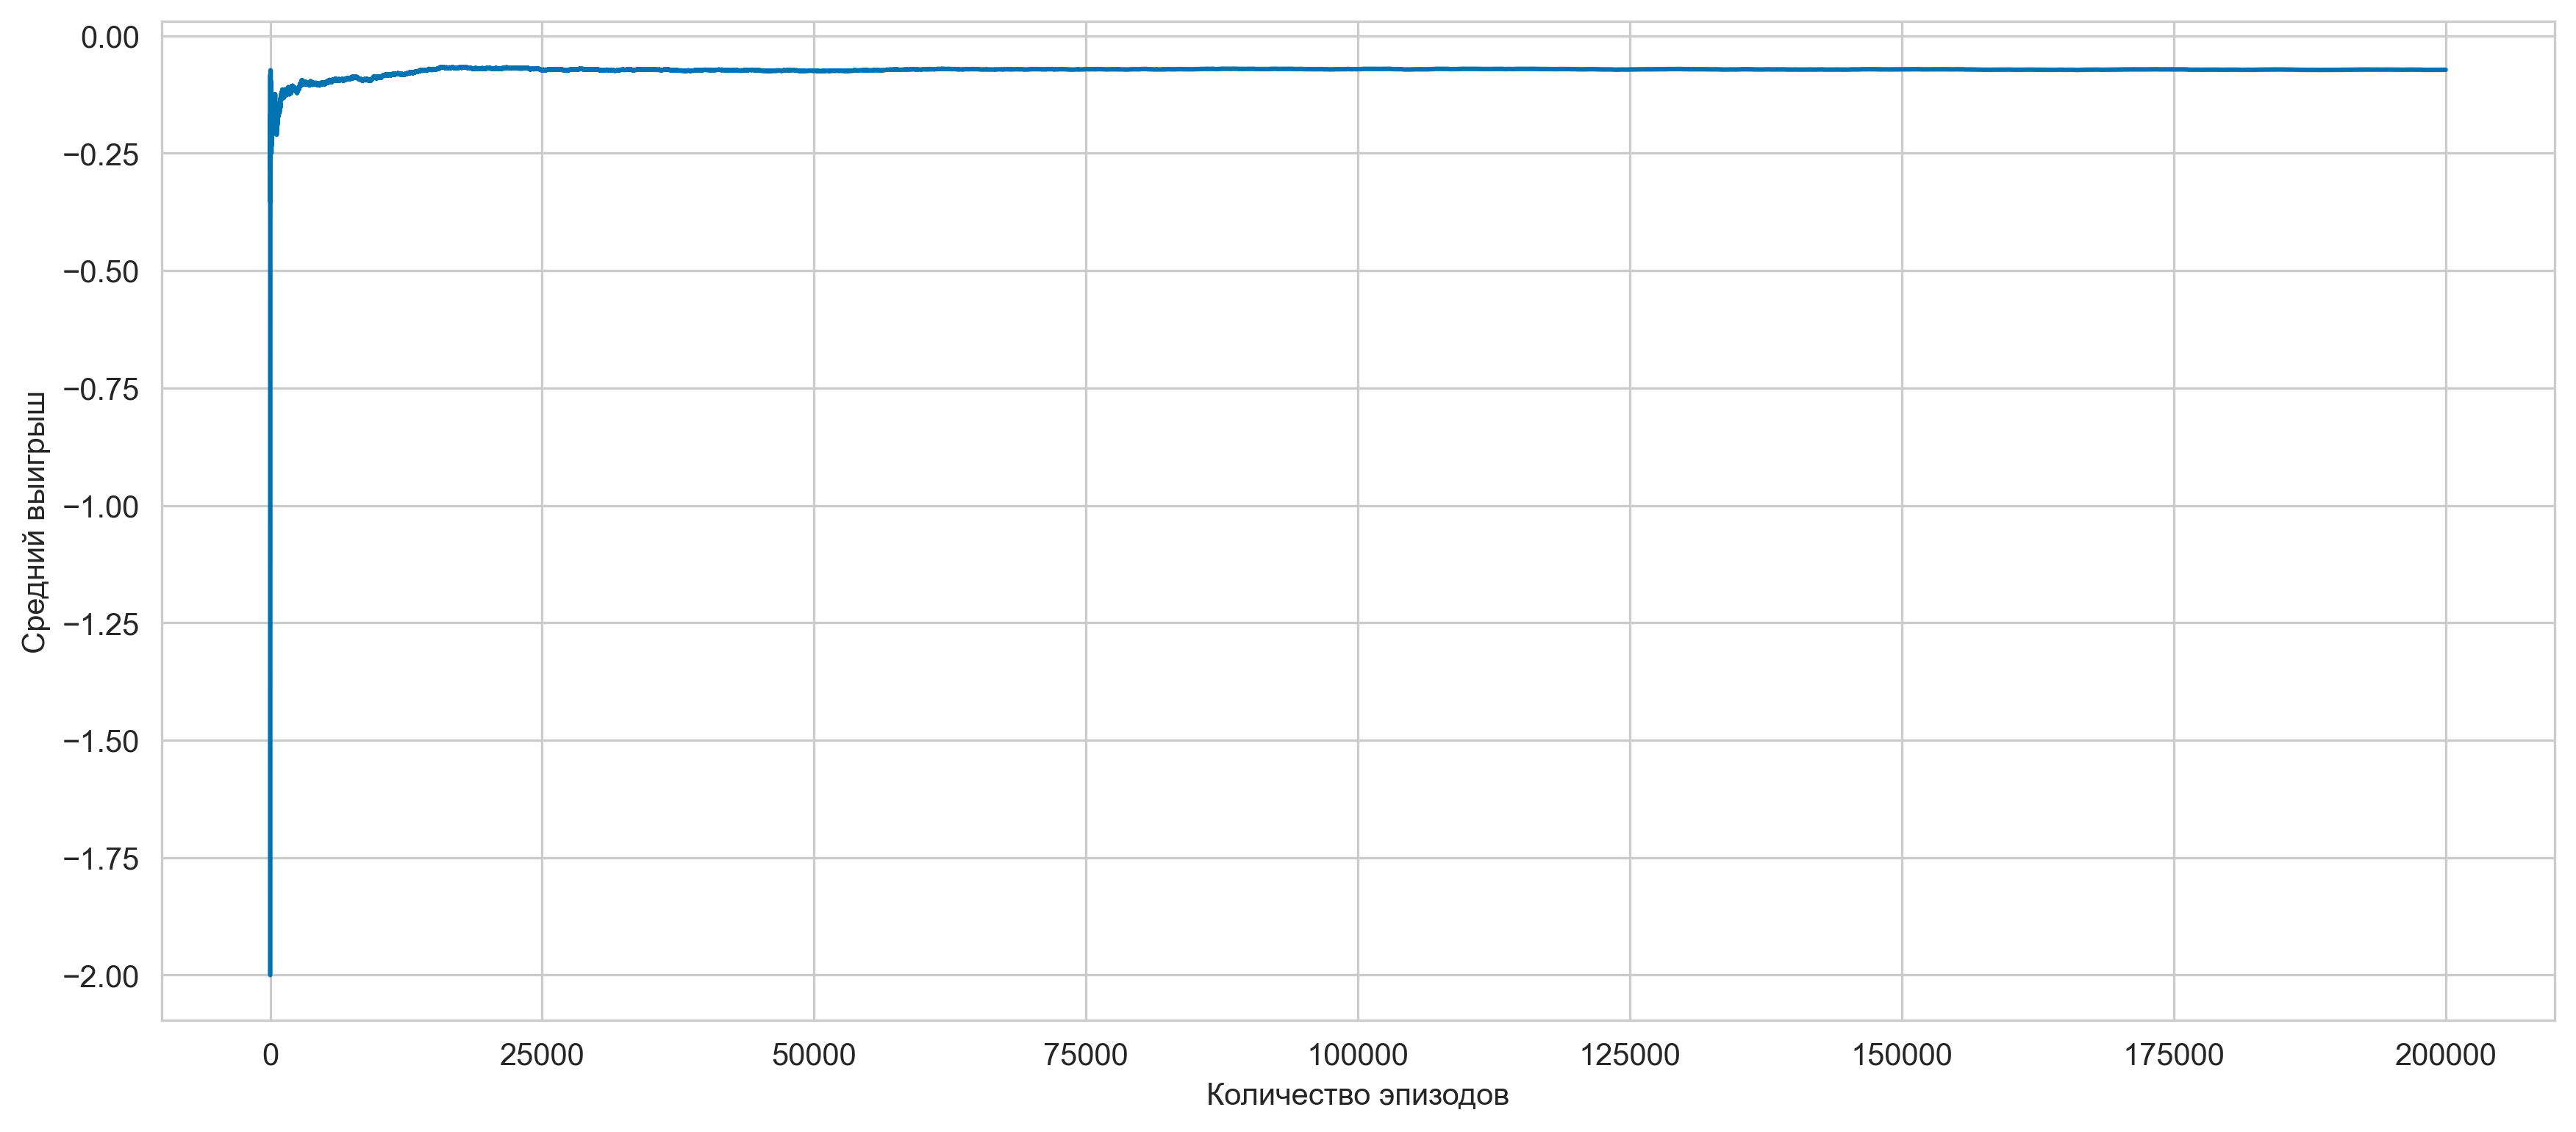

Средний выигрыш после 200000 эпизодов: -0.0724575
Wall time: 18.8 s


-0.0724575

In [50]:
%%time
episodes = 200_000
run_experiments(env, episodes, pi_q)

Средний выигрыш стратегии, обученной методом On-policy Monte Carlo control:

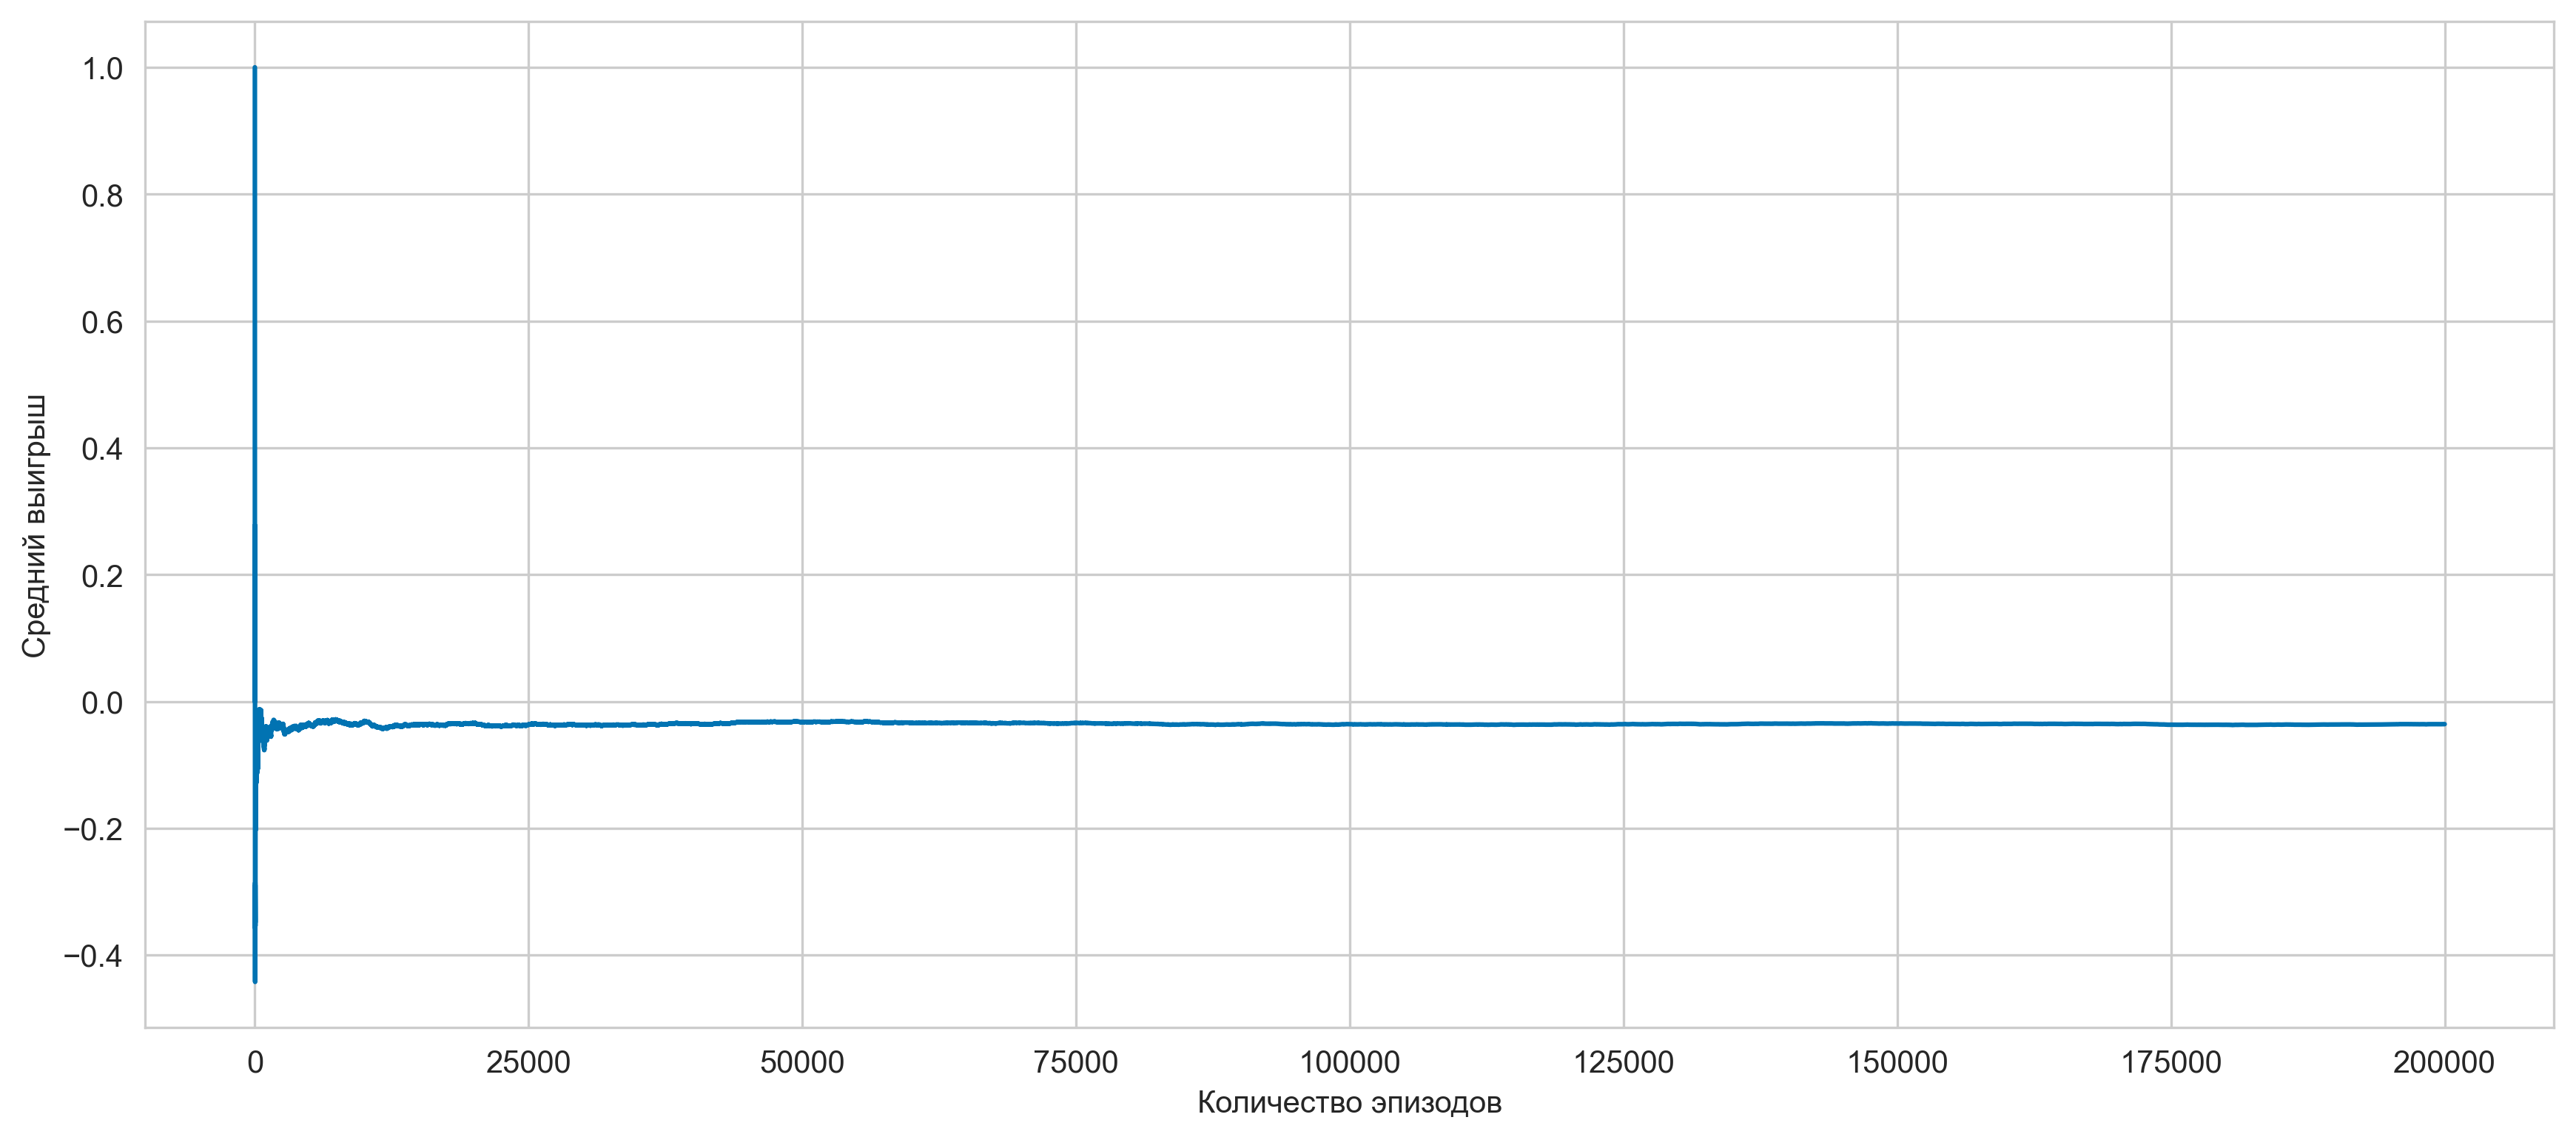

Средний выигрыш после 200000 эпизодов: -0.0358375
Wall time: 18.2 s


-0.0358375

In [51]:
%%time
run_experiments(env, episodes, pi_mc)

Проведем подбор гиперпараметров для варианта блэкджека с удвоением

In [52]:
episodes = 100_000
gamma_list = [1, 0.95, 0.9, 0.8]
eps_list = [0.01, 0.05, 0.1, 0.2]
best_avg_reward = -np.inf
best_hyperparameters = None
for gamma in gamma_list:
    for eps in eps_list:
        Q, pi = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)
        avg_reward = run_experiments(env = env, episodes = episodes, pi = pi_mc, plot = False) 
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_hyperparameters = (gamma, eps)

print(f'Best (gamma, eps): {best_hyperparameters}')
print(f'Average reward: {best_avg_reward}')

Best (gamma, eps): (0.9, 0.01)
Average reward: -0.0288


Используя подобранные гиперпараметры, попробуем обучить стратегию на большом количестве эпизодов, а затем сыграть обученной стратегией 1_000_000 игр

In [53]:
%%time
episodes, gamma, eps = 1_000_000, 0.9, 0.01
_, pi_mc_best = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Wall time: 2min 16s


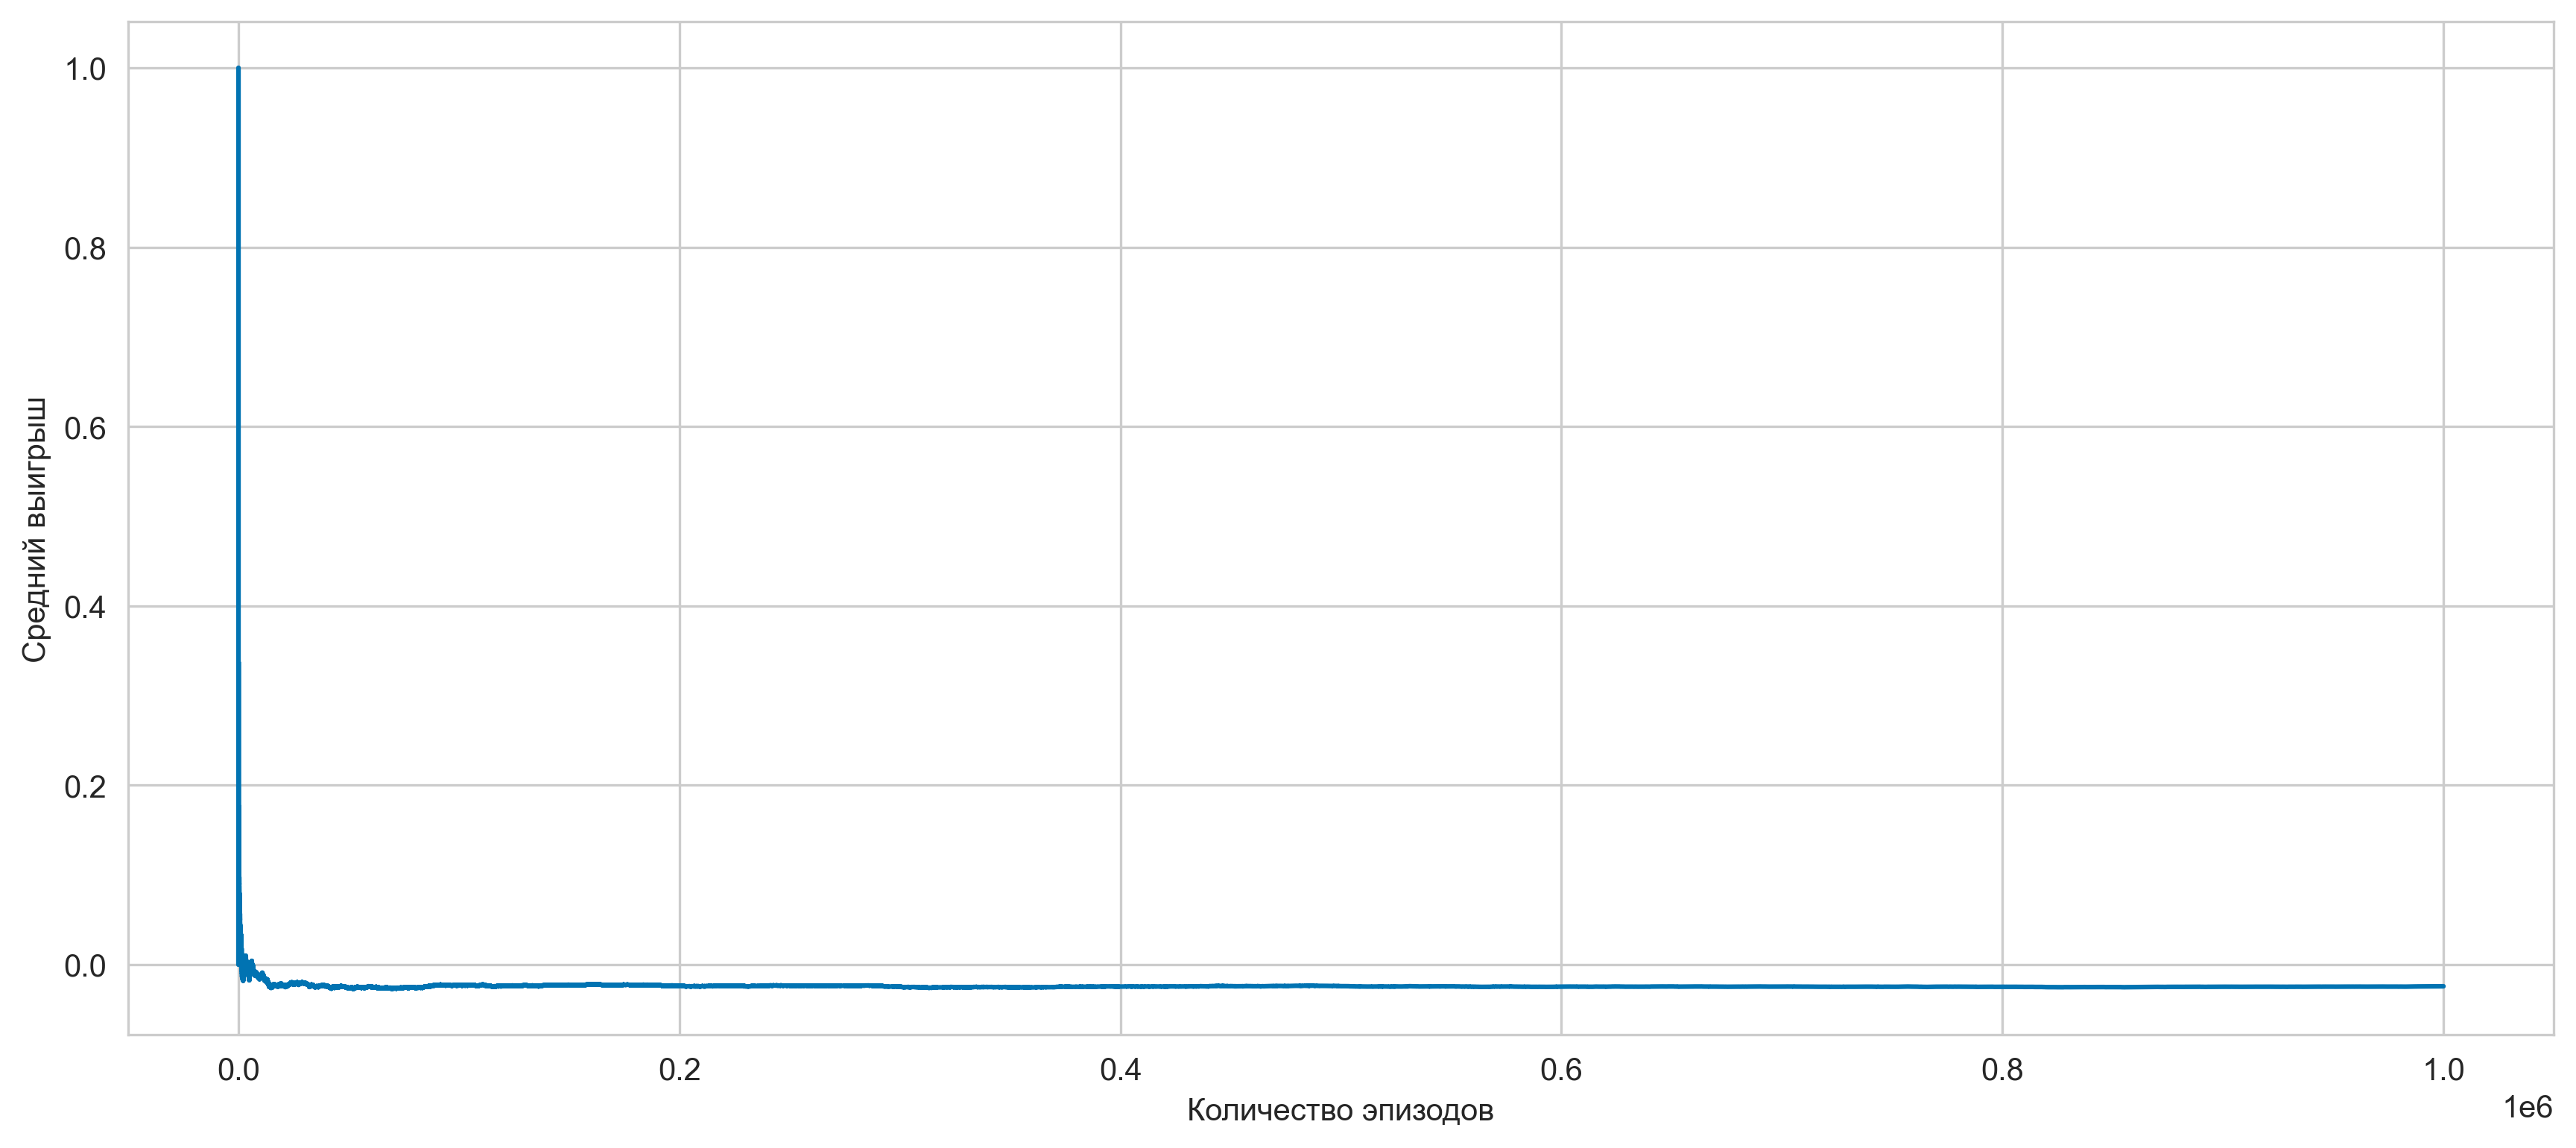

Средний выигрыш после 1000000 эпизодов: -0.0240145
Wall time: 1min 29s


-0.0240145

In [54]:
%%time
run_experiments(env, episodes, pi_mc_best)

In [109]:
env.close()

**Выводы по части II:**  
1) В игре с удвоением алгоритм On-policy Monte Carlo control также показал более лучший результат по сравнению с Q-learning.  
2) С его помощью удалось повысить средний выигрыш до -0.0358375 по сравнению с обычным блэкджеком (с одинаковими базовыми параметрами episodes, gamma, eps = 200_000, 1, 0.05 в обычном блэкджеке получили средний выигрыш -0.0444475).  
3) Подбор гиперпараметров и последующее обучение и проведение экспериментов на 1_000_000 игр позволило улучшить результат до -0.0240145 (в первой части было -0.028921).  
4) Казино все равно выигрывает...

[К содержанию](#zero-bullet) 

## 4. Часть III, в главной роли — Дастин Хоффман <a class="anchor" id="III"></a>   

Условие задачи: *А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт. Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.*

### 6. Реализация варианта блекджека с удвоением ставки и подсчетом карт <a class="anchor" id="6"></a>  

Условие задачи: *Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет)*
https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [5]:
class CountCardsBlackjackEnv(gym.Env):
    def __init__(self, natural = False):
        self.action_space = spaces.Discrete(3) # add third action
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()
        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.const_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.const_deck * 4
        # dict for counting
        self.plus_minus = {2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0, 8: 0, 9: 0, 10: -1, 1: -1}
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def cards_count(self, deck):
        return len(deck)

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:  # double action
            self.player.append(self.draw_card(self.np_random))
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            reward *= 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), 
                np.sum([self.plus_minus[card] for card in self.deck])) 

    def reset(self):
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        
        if self.cards_count(self.deck) <= 15:
            self.deck = self.const_deck * 4
        return self._get_obs()
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def show_cards(self):
        return self.player

In [6]:
env = CountCardsBlackjackEnv(natural = True)

[К содержанию](#zero-bullet) 

### 7. Обучение стратегии для блекджека с удвоением ставки и подсчетом карт <a class="anchor" id="7"></a>  

Условие задачи: *Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные  п.2-3.*

In [7]:
episodes, gamma, eps = 200_000, 0.9, 0.05
_, pi_q  = Q_learning(env = env, episodes = episodes, gamma = gamma, epsilon = eps, alpha = 0.001)
_, pi_mc = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Episode 200000/200000.

Средний выигрыш стратегии, обученной методом Q-learning:

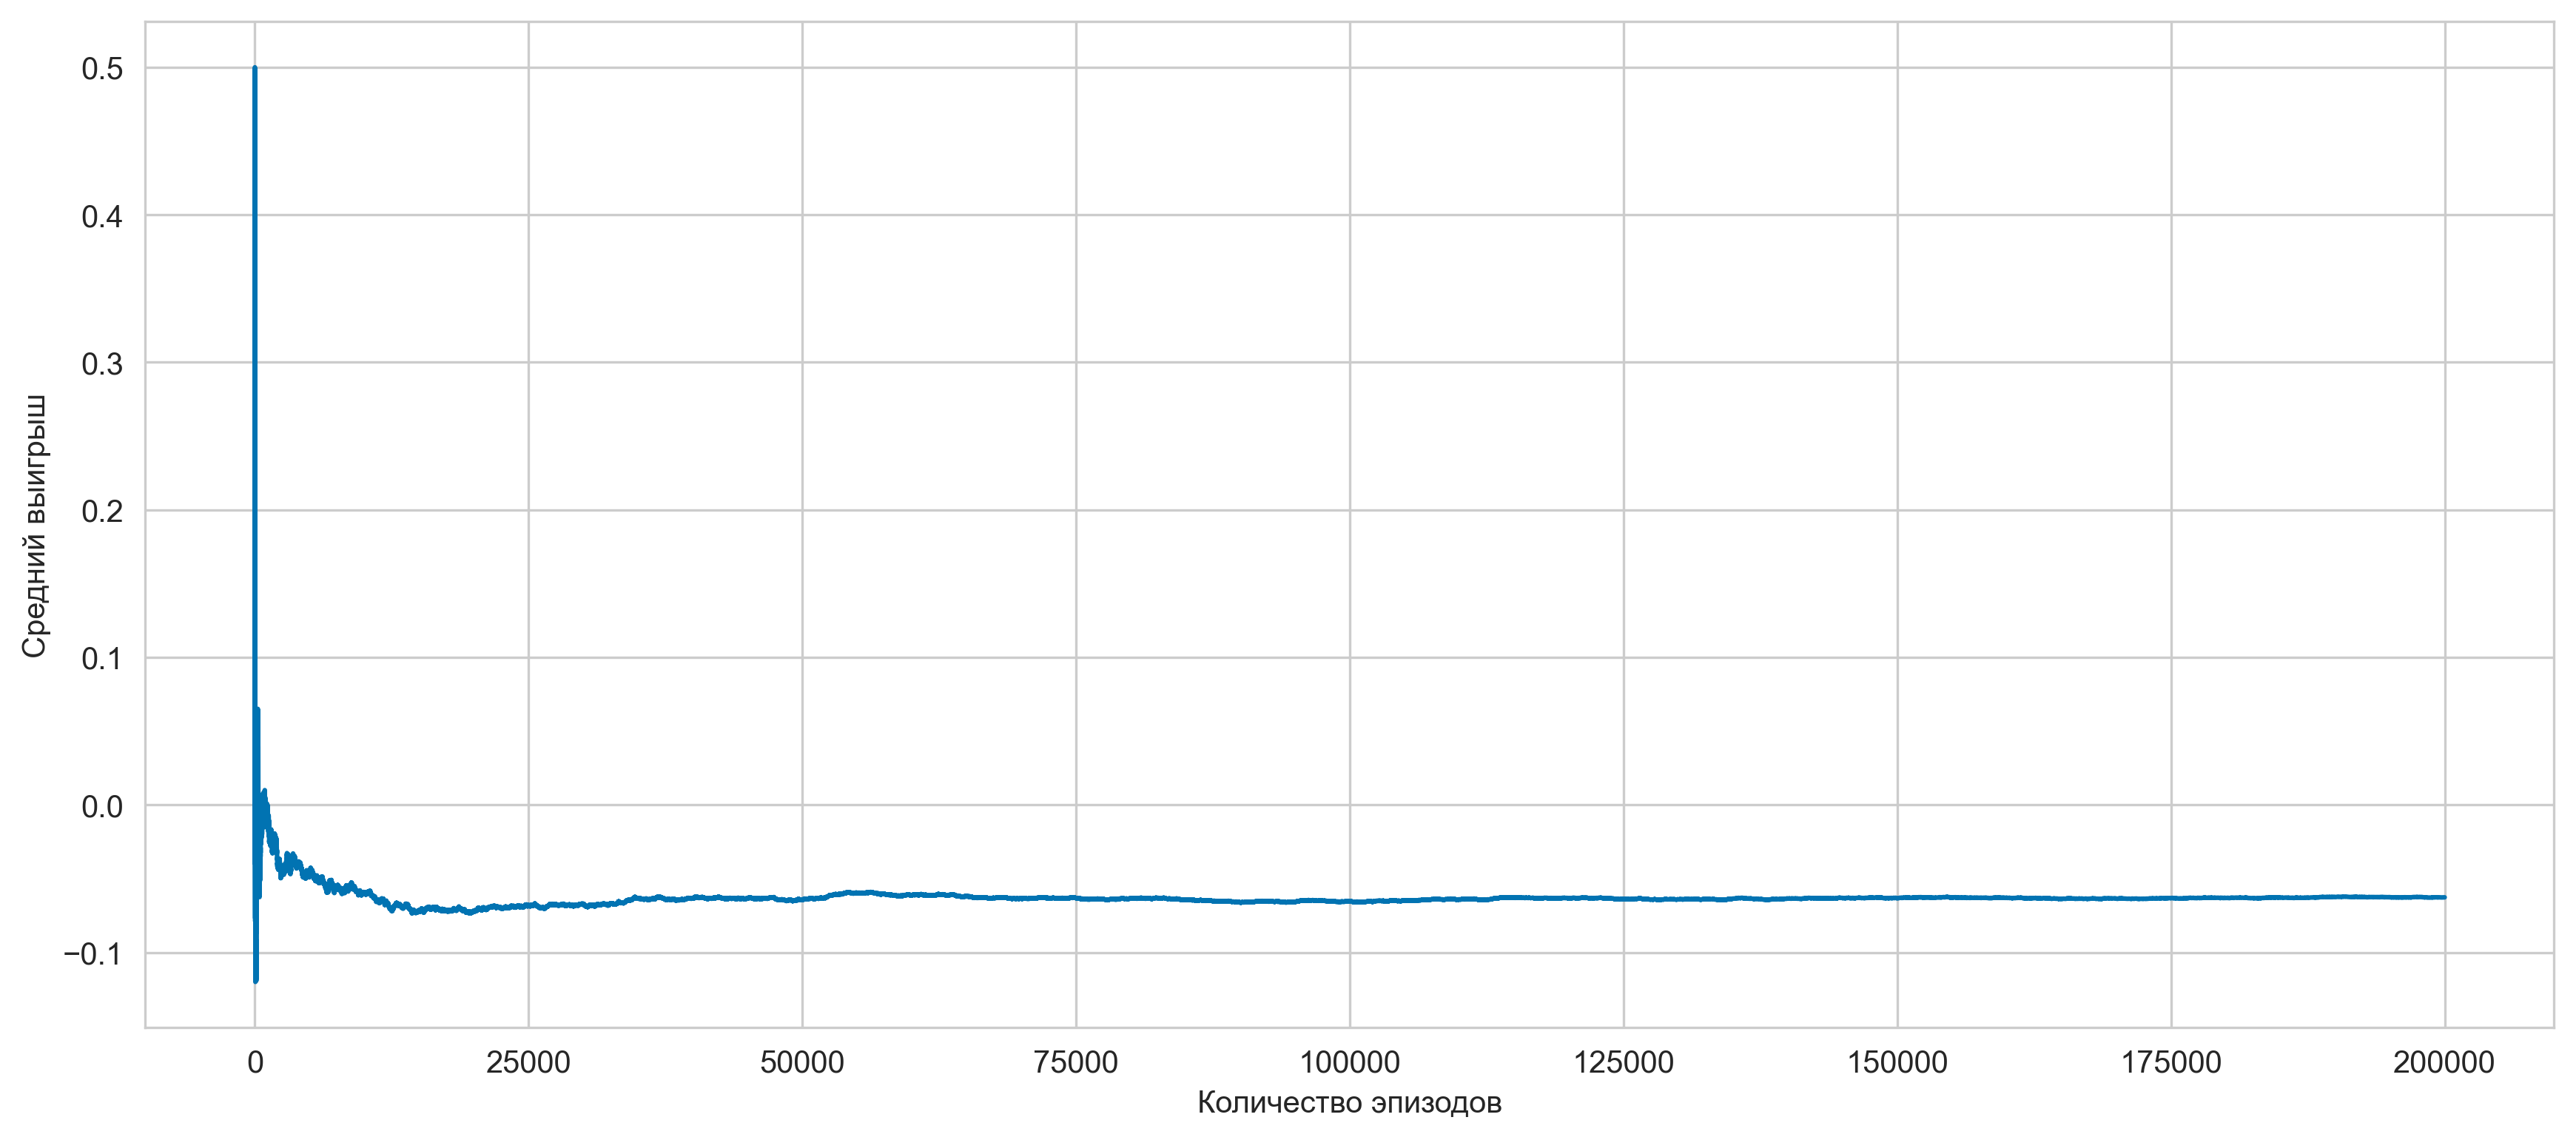

Средний выигрыш после 200000 эпизодов: -0.06269
Wall time: 28.4 s


-0.06269

In [120]:
%%time
episodes = 200_000
run_experiments(env, episodes, pi_q)

Средний выигрыш стратегии, обученной методом On-policy Monte Carlo control:

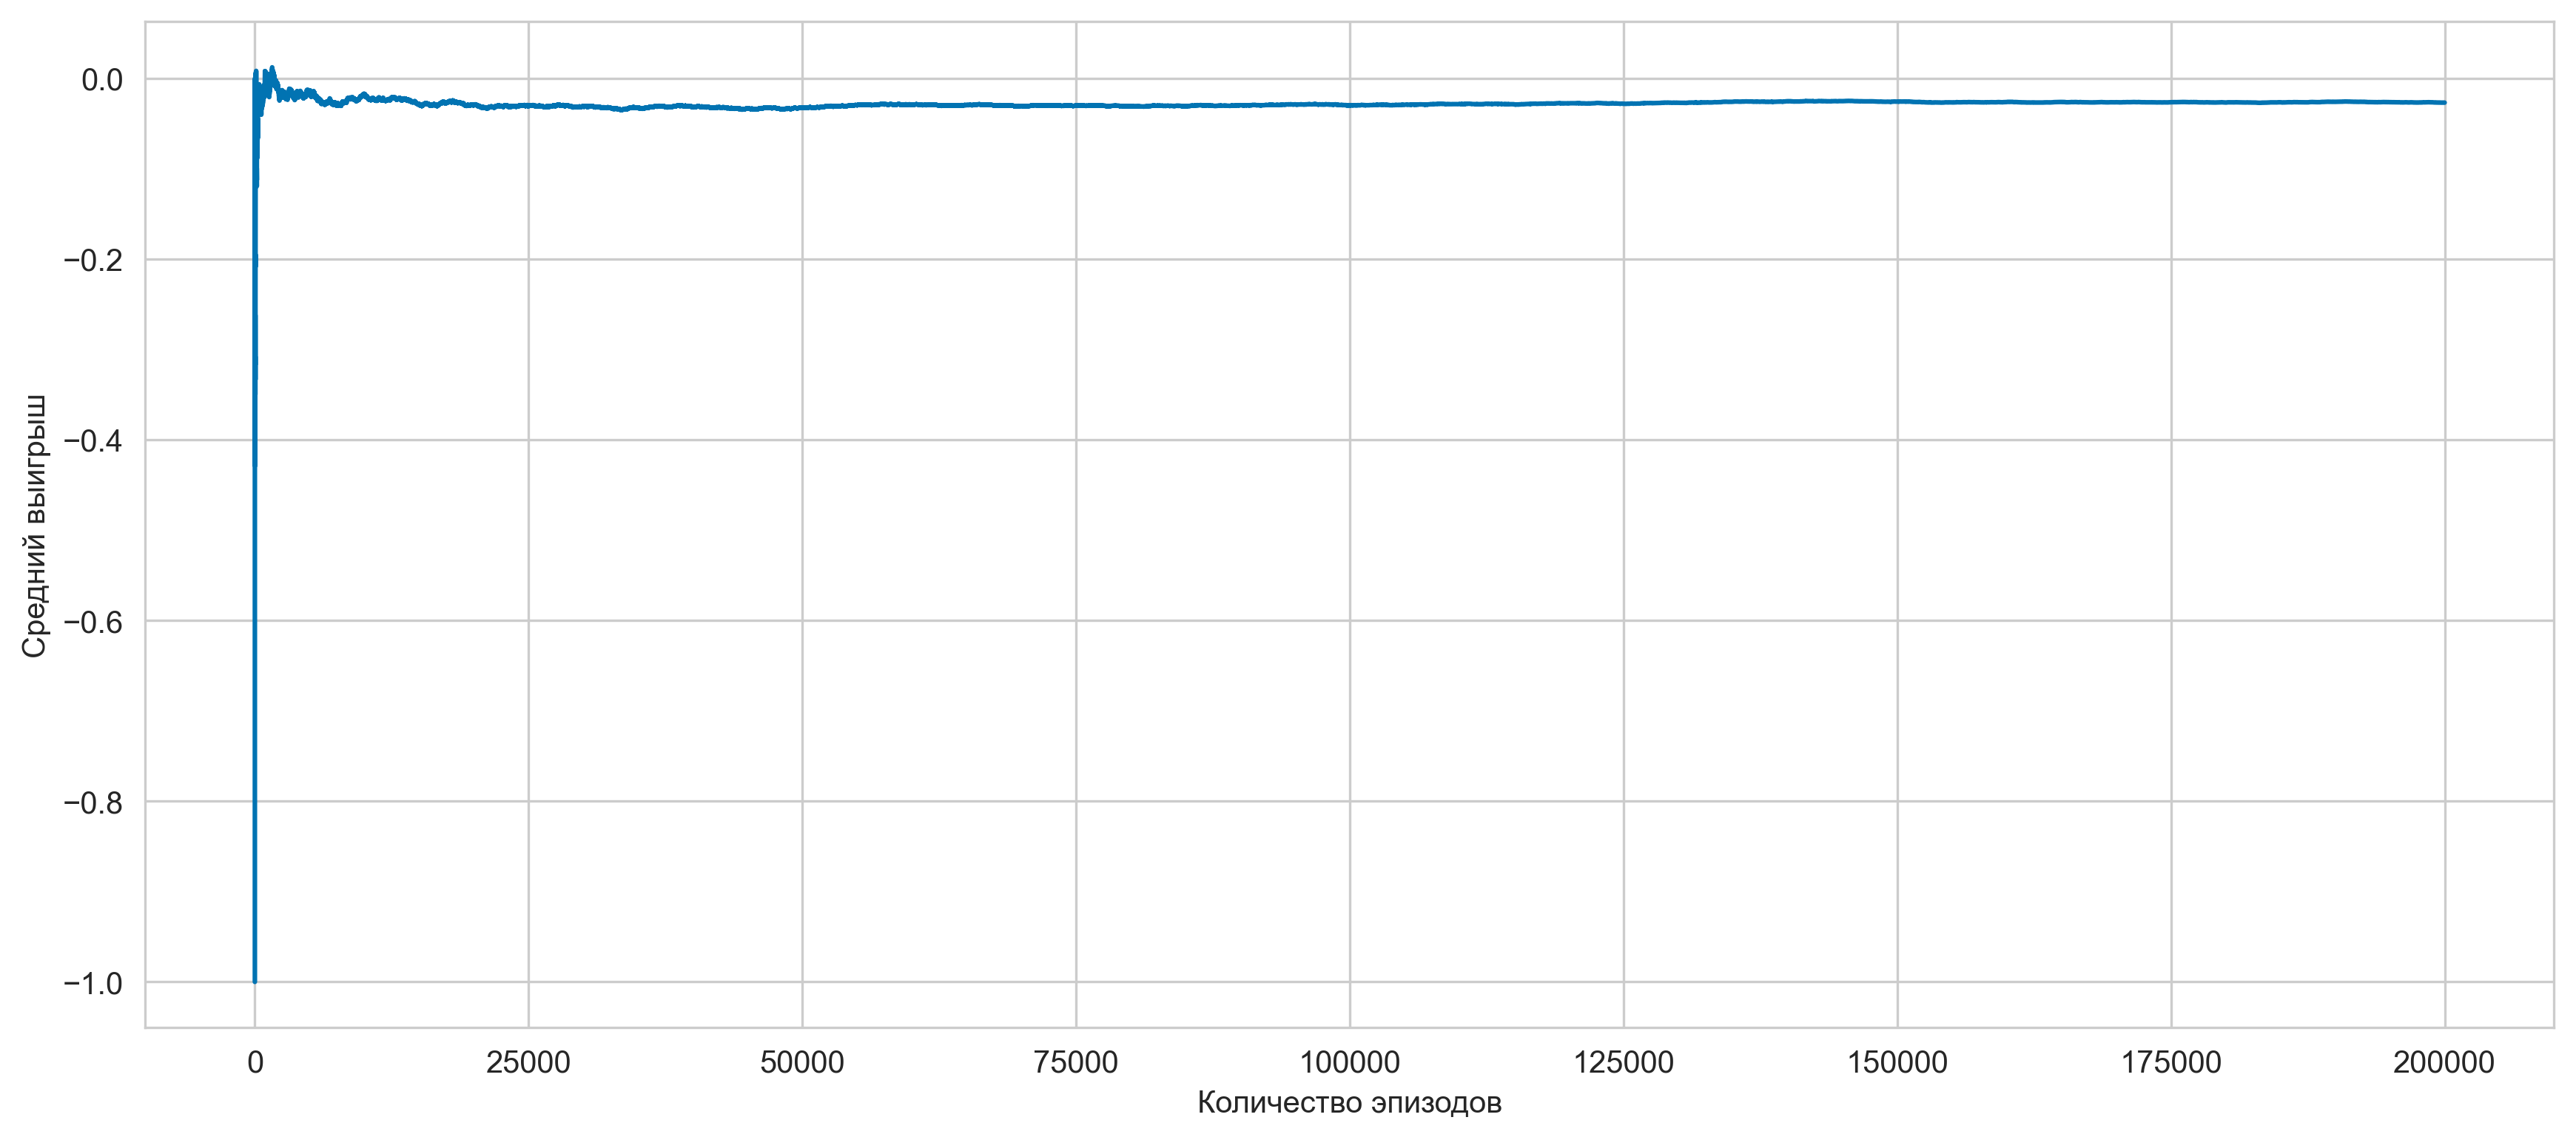

Средний выигрыш после 200000 эпизодов: -0.026725
Wall time: 28.5 s


-0.026725

In [121]:
%%time
run_experiments(env, episodes, pi_mc)

Проведем подбор гиперпараметров для варианта блэкджека с удвоением и подсчетом

In [8]:
episodes = 100_000
gamma_list = [1, 0.95, 0.9, 0.8]
eps_list = [0.01, 0.05, 0.1, 0.2]
best_avg_reward = -np.inf
best_hyperparameters = None
for gamma in gamma_list:
    for eps in eps_list:
        Q, pi = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)
        avg_reward = run_experiments(env = env, episodes = episodes, pi = pi_mc, plot = False) 
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            best_hyperparameters = (gamma, eps)

print(f'Best (gamma, eps): {best_hyperparameters}')
print(f'Average reward: {best_avg_reward}')

Best (gamma, eps): (0.8, 0.01)
Average reward: -0.056775


Используя подобранные гиперпараметры, попробуем обучить стратегию на большом количестве эпизодов, а затем сыграть обученной стратегией 1_000_000 игр

In [10]:
episodes, gamma, eps = 1_000_000, 0.8, 0.01
_, pi_mc_best = on_policy_mc_control(env = env, episodes = episodes, gamma = gamma, epsilon = eps)

Episode 1000000/1000000.

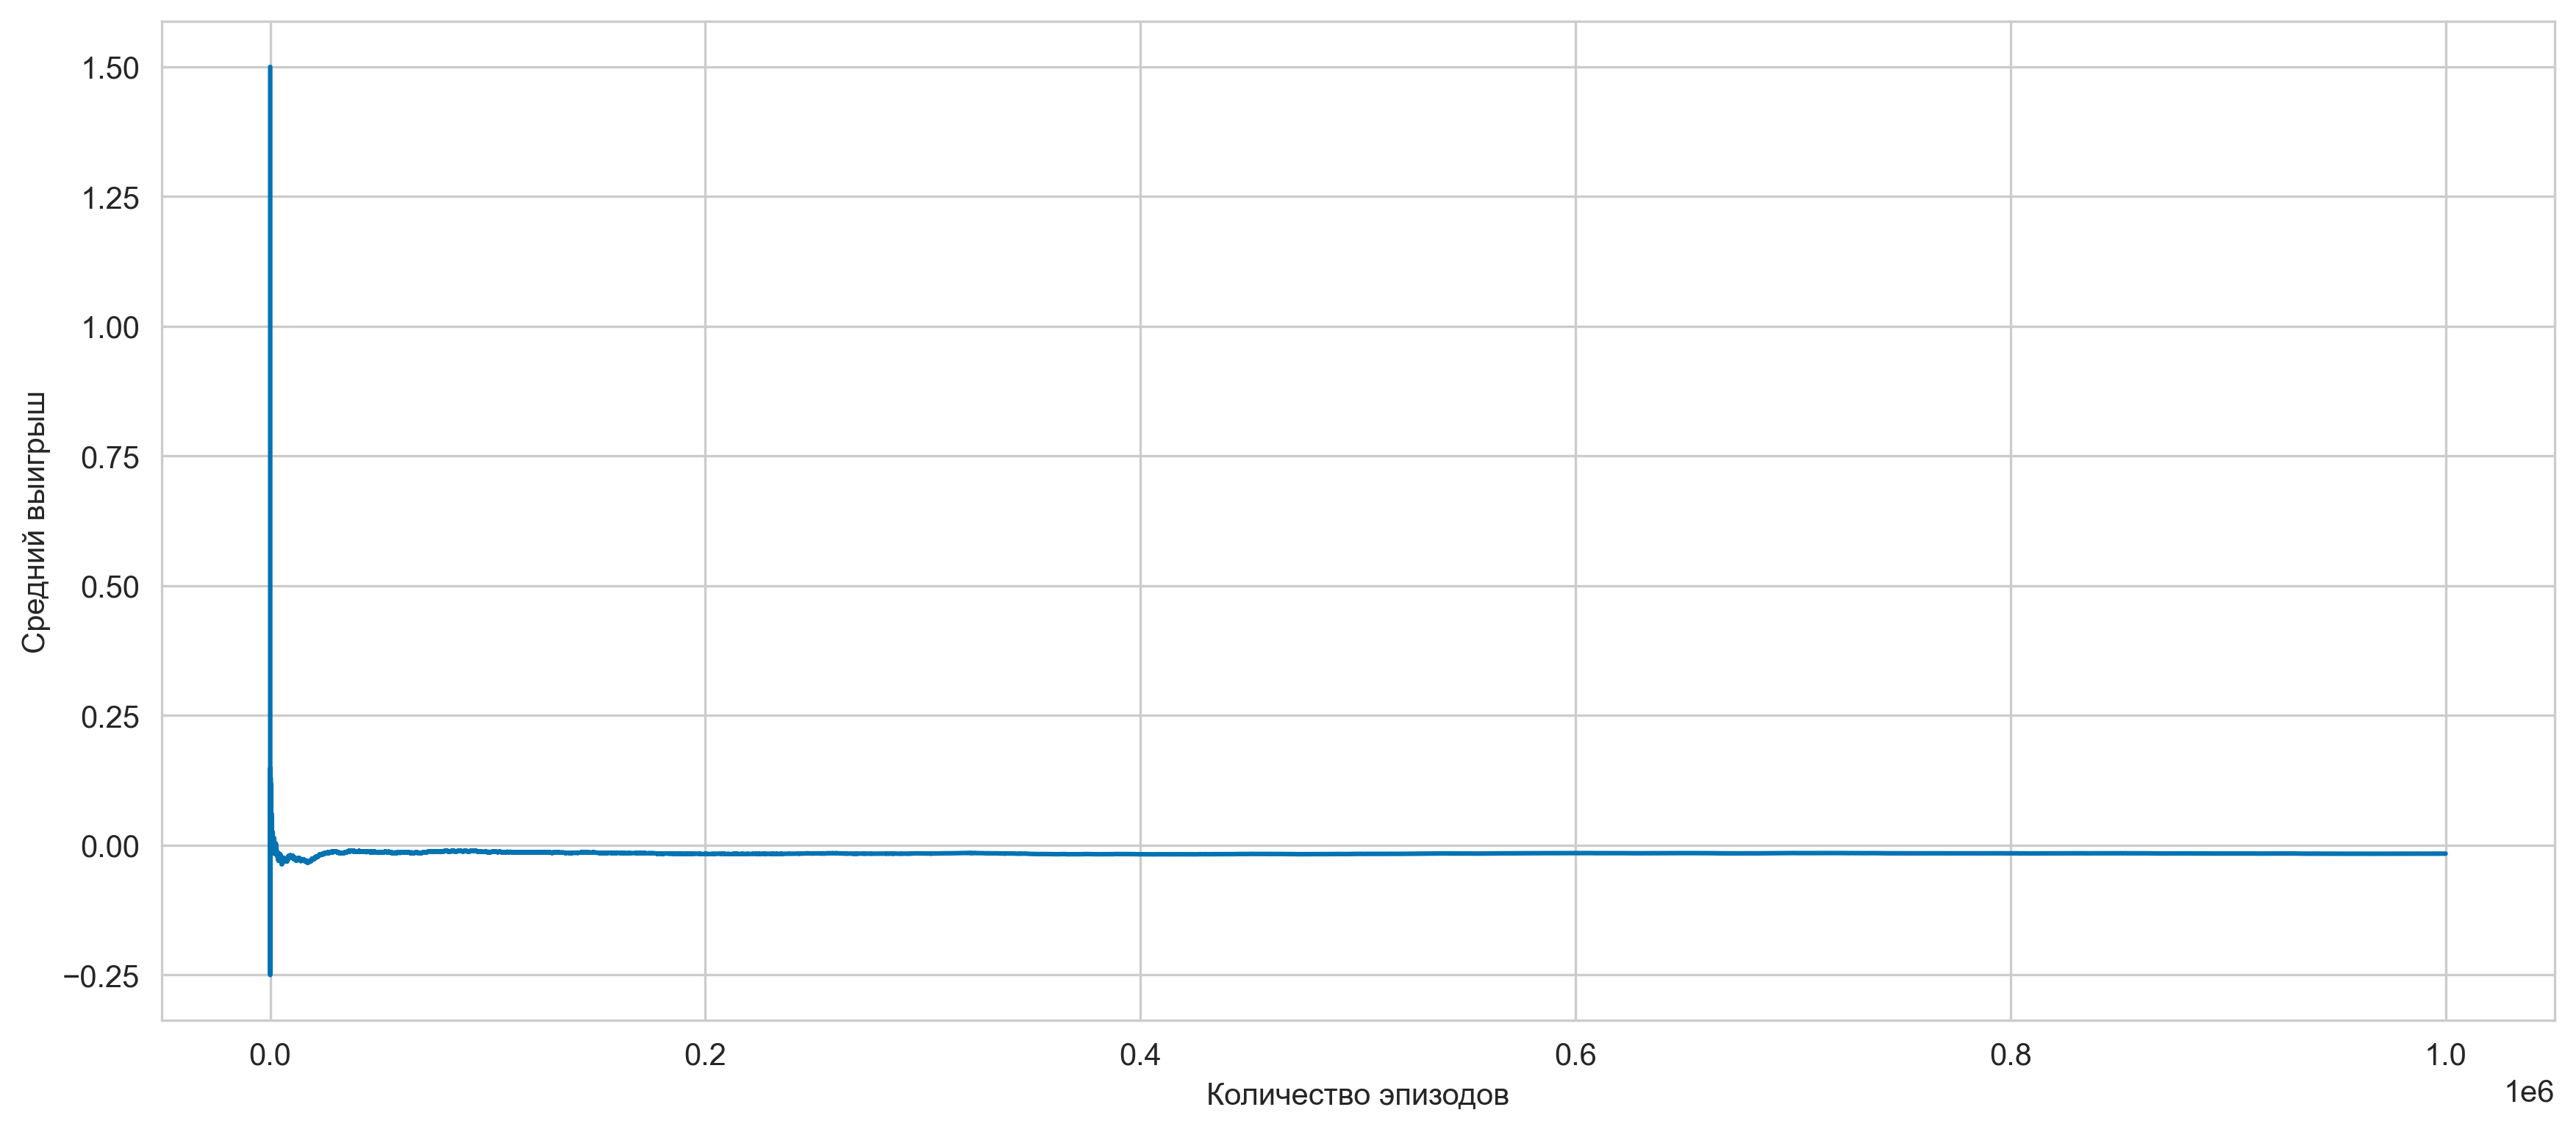

Средний выигрыш после 1000000 эпизодов: -0.0161525
Wall time: 2min 17s


-0.0161525

In [101]:
%%time
run_experiments(env, episodes, pi_mc_best)

In [ ]:
env.close()

**Выводы по части III:**  
1) В игре с удвоением и подсчетом алгоритм On-policy Monte Carlo control также показал более лучший результат по сравнению с Q-learning.  
2) С его помощью удалось повысить средний выигрыш до -0.026725 (по сравнению с наилучшим результатом части II: -0.028921 ).  
3) Подбор гиперпараметров и последующее обучение и проведение экспериментов на 1_000_000 игр позволило улучшить результат до -0.0161525 (во второй части было -0.0240145).  
4) Обыграть казино так и не удалось...

[К содержанию](#zero-bullet) 

**Интересные наблюдения**  

Если посмотреть на полученные в ходе перебора гиперпараметры, то можно увидеть следующее:  
Часть 1: gamma = 0.9, eps = 0.2  
Часть 2: gamma = 0.9, eps = 0.01  
Часть 3: gamma = 0.8, eps = 0.01  

Напблюдается интересная тенденция: при переходе от части к части для агента происходит улучшение ситуации (появляется больше информации и бОльший простор для действий). При этом оптимальный эпсилон уменьшается, что свидетельствует о том, что агент начинает играть более детерминированно - и в этом есть определенная логика. Кроме того, уменьшается значение дисконтирования - агент начинает играть более "агрессивно" и прямолинейно, что также объясняется его бОльшей осведомленностью.

## Часть IV, опциональная <a class="anchor" id="IV"></a>  

### 8. Решение уравнений Беллмана <a class="anchor" id="8"></a>  

Условие задачи: *Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. найти или обучить вероятности переходов между состояниями.*

In [11]:
# to be continued...

[К содержанию](#zero-bullet) 